# 基础LSTM犯罪预测模型 - 改进版

本notebook实现了一个改进的LSTM时间序列预测模型，主要改进点：
- **数据清洗**: 处理1月1日录入异常、月末异常值
- **时间范围**: 只使用2010-2023年完整数据（排除2024-2025不完整数据）
- **异常值处理**: 使用滚动窗口识别并平滑异常尖峰
- **模型结构**: 3层LSTM + BatchNormalization + Dropout
- **损失函数**: Huber损失（对异常值更鲁棒）

In [24]:
# 导入所需库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# 设置绘图样式
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ 库导入完成")

✅ 库导入完成


## 1. 数据加载与初步清洗

In [25]:
# 加载数据
file_path = '/Users/mannormal/Desktop/课程/y4t1/stat 4011/part2/cleaned_data/Crime_Data_2010_to_Present_Cleaned_merged_and_deduped_20250929_add_by_def_fill_some_v3.1.csv'
print(f"正在加载数据: {file_path}")
df = pd.read_csv(file_path)
print(f"原始数据: {len(df):,} 条记录")

# 转换日期
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], errors='coerce')
df = df.dropna(subset=['DATE OCC'])

# 🔍 检查2015年数据质量问题
print("\n" + "=" * 60)
print("检查2015年数据质量")
print("=" * 60)

df_2015 = df[df['DATE OCC'].dt.year == 2015]
if 'AREA' in df.columns:
    # 统计每个地区2015年的数据量
    area_counts_2015 = df_2015.groupby('AREA').size().sort_values()
    print(f"\n2015年各地区数据量:")
    print(area_counts_2015.head(10))
    
    # 计算其他年份的平均数据量
    df_other_years = df[df['DATE OCC'].dt.year != 2015]
    area_counts_other = df_other_years.groupby('AREA').size() / df_other_years['DATE OCC'].dt.year.nunique()
    
    # 识别2015年数据异常少的地区（少于其他年份平均值的50%）
    problematic_areas = []
    for area in area_counts_2015.index:
        if area in area_counts_other.index:
            if area_counts_2015[area] < area_counts_other[area] * 0.5:
                problematic_areas.append(area)
    
    print(f"\n识别到 {len(problematic_areas)} 个2015年数据异常的地区:")
    for area in problematic_areas[:10]:  # 只显示前10个
        count_2015 = area_counts_2015.get(area, 0)
        count_avg = area_counts_other.get(area, 0)
        print(f"  地区 {area}: 2015年={count_2015:.0f}, 其他年份均值={count_avg:.0f}, 比例={count_2015/count_avg:.1%}")
    
    # 选择是否移除这些地区的数据
    if len(problematic_areas) > 0:
        print(f"\n⚠️  发现 {len(problematic_areas)} 个地区在2015年数据异常")
        print(f"移除这些地区的所有数据（不仅是2015年）...")
        df_filtered = df[~df['AREA'].isin(problematic_areas)]
        print(f"移除后数据: {len(df_filtered):,} 条记录 (移除了 {len(df) - len(df_filtered):,} 条)")
    else:
        print("\n✅ 未发现明显的地区数据异常")
        df_filtered = df.copy()
else:
    print("\n⚠️  数据中没有AREA列，无法识别问题地区")
    df_filtered = df.copy()

# 时间范围过滤: 2010-2023 (移除2024和2025不完整数据)
start_date = '2010-01-01'
end_date = '2023-12-31'
df_filtered = df_filtered[(df_filtered['DATE OCC'] >= start_date) & (df_filtered['DATE OCC'] <= end_date)]
print(f"\n筛选2010-2023年数据: {len(df_filtered):,} 条记录")

# 按天聚合
daily_crimes = df_filtered.groupby('DATE OCC').size().reset_index(name='crime_count')
daily_crimes = daily_crimes.set_index('DATE OCC')

# 确保连续时间序列
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
daily_crimes = daily_crimes.reindex(date_range, fill_value=0)

print(f"\n生成连续日期序列: {len(daily_crimes)} 天")
print(f"\n初步统计:")
print(f"  - 日均犯罪: {daily_crimes['crime_count'].mean():.2f}")
print(f"  - 标准差: {daily_crimes['crime_count'].std():.2f}")
print(f"  - 最小值: {daily_crimes['crime_count'].min()}")
print(f"  - 最大值: {daily_crimes['crime_count'].max()}")

正在加载数据: /Users/mannormal/Desktop/课程/y4t1/stat 4011/part2/cleaned_data/Crime_Data_2010_to_Present_Cleaned_merged_and_deduped_20250929_add_by_def_fill_some_v3.1.csv
原始数据: 3,079,521 条记录
原始数据: 3,079,521 条记录

检查2015年数据质量

2015年各地区数据量:
AREA
19       1
20       3
18     871
16    7331
4     7771
7     8002
10    8246
2     9004
8     9221
5     9230
dtype: int64

检查2015年数据质量

2015年各地区数据量:
AREA
19       1
20       3
18     871
16    7331
4     7771
7     8002
10    8246
2     9004
8     9221
5     9230
dtype: int64

识别到 3 个2015年数据异常的地区:
  地区 19: 2015年=1, 其他年份均值=8914, 比例=0.0%
  地区 20: 2015年=3, 其他年份均值=9061, 比例=0.0%
  地区 18: 2015年=871, 其他年份均值=10042, 比例=8.7%

⚠️  发现 3 个地区在2015年数据异常
移除这些地区的所有数据（不仅是2015年）...

识别到 3 个2015年数据异常的地区:
  地区 19: 2015年=1, 其他年份均值=8914, 比例=0.0%
  地区 20: 2015年=3, 其他年份均值=9061, 比例=0.0%
  地区 18: 2015年=871, 其他年份均值=10042, 比例=8.7%

⚠️  发现 3 个地区在2015年数据异常
移除这些地区的所有数据（不仅是2015年）...
移除后数据: 2,658,391 条记录 (移除了 421,130 条)
移除后数据: 2,658,391 条记录 (移除了 421,130 条)

筛选2010-2023年数据: 2,547,529 条记录


## 2. 异常值处理

处理三类异常：
1. **1月1日异常**: 警察局数据录入问题导致的异常峰值
2. **月末异常**: 月末数据录入集中导致的异常
3. **其他异常尖峰**: 使用3σ准则识别并平滑

In [26]:
# 保存原始数据用于对比
daily_crimes_original = daily_crimes.copy()

# 计算正常中位数(排除1月1日)
jan_1st_mask = daily_crimes.index.dayofyear == 1
normal_median = daily_crimes[~jan_1st_mask]['crime_count'].median()
print(f"正常日期中位数: {normal_median:.2f}")

# 1. 处理1月1日异常
jan_1st_count = daily_crimes[jan_1st_mask]['crime_count']
jan_1st_anomaly = (jan_1st_count > 3 * normal_median).sum()
daily_crimes.loc[jan_1st_mask, 'crime_count'] = daily_crimes[jan_1st_mask]['crime_count'].apply(
    lambda x: normal_median if x > 3 * normal_median else x
)
print(f"修正1月1日异常: {jan_1st_anomaly} 个")

# 2. 处理月末异常
month_end_mask = daily_crimes.index.is_month_end
month_end_count = daily_crimes[month_end_mask]['crime_count']
month_end_anomaly = (month_end_count > 3 * normal_median).sum()
daily_crimes.loc[month_end_mask, 'crime_count'] = daily_crimes[month_end_mask]['crime_count'].apply(
    lambda x: normal_median if x > 3 * normal_median else x
)
print(f"修正月末异常: {month_end_anomaly} 个")

# 3. 滚动窗口平滑异常尖峰
rolling_mean = daily_crimes['crime_count'].rolling(window=7, center=True).mean()
rolling_std = daily_crimes['crime_count'].rolling(window=7, center=True).std()
outlier_mask = np.abs(daily_crimes['crime_count'] - rolling_mean) > 3 * rolling_std
outlier_count = outlier_mask.sum()
daily_crimes.loc[outlier_mask, 'crime_count'] = rolling_mean[outlier_mask]
print(f"平滑其他异常点: {outlier_count} 个")

# 填充NaN
daily_crimes = daily_crimes.fillna(method='bfill').fillna(method='ffill')

print(f"\n总共修正异常值: {jan_1st_anomaly + month_end_anomaly + outlier_count} 个")
print(f"\n清洗后数据统计:")
print(f"  - 日均犯罪: {daily_crimes['crime_count'].mean():.2f}")
print(f"  - 标准差: {daily_crimes['crime_count'].std():.2f}")
print(f"  - 最小值: {daily_crimes['crime_count'].min()}")
print(f"  - 最大值: {daily_crimes['crime_count'].max()}")

正常日期中位数: 490.00
修正1月1日异常: 3 个
修正月末异常: 0 个
平滑其他异常点: 0 个

总共修正异常值: 3 个

清洗后数据统计:
  - 日均犯罪: 497.47
  - 标准差: 73.73
  - 最小值: 117
  - 最大值: 1436


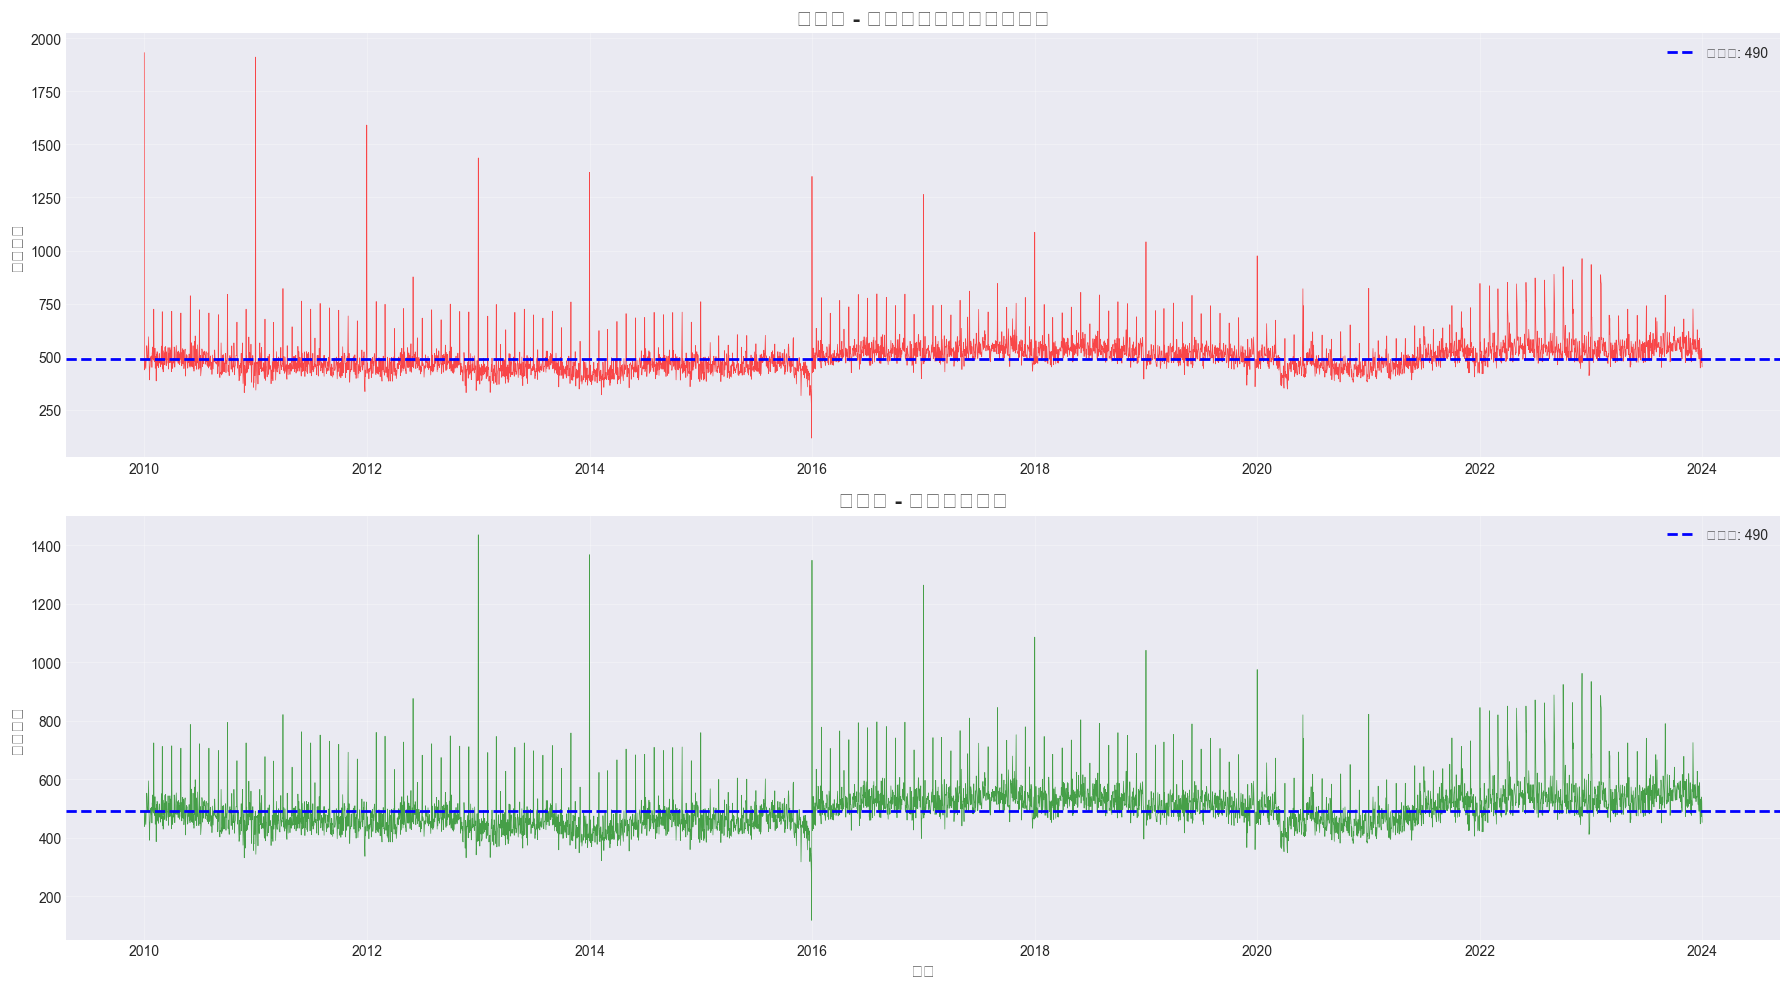


指标              清洗前             清洗后             变化             
平均值             498.25          497.47          -0.78          
标准差             80.39           73.73           -6.66          
最大值             1932            1436            -496           
最小值             117             117             0              


In [27]:
# 可视化：清洗前后对比
fig, axes = plt.subplots(2, 1, figsize=(18, 10))

# 清洗前
axes[0].plot(daily_crimes_original.index, daily_crimes_original['crime_count'], 
             alpha=0.7, linewidth=0.5, color='red')
axes[0].axhline(y=daily_crimes_original['crime_count'].median(), 
                color='blue', linestyle='--', linewidth=2, label=f'中位数: {daily_crimes_original["crime_count"].median():.0f}')
axes[0].set_title('清洗前 - 原始数据（包含异常值）', fontsize=16, fontweight='bold')
axes[0].set_ylabel('犯罪数量', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# 清洗后
axes[1].plot(daily_crimes.index, daily_crimes['crime_count'], 
             alpha=0.7, linewidth=0.5, color='green')
axes[1].axhline(y=daily_crimes['crime_count'].median(), 
                color='blue', linestyle='--', linewidth=2, label=f'中位数: {daily_crimes["crime_count"].median():.0f}')
axes[1].set_title('清洗后 - 异常值已修正', fontsize=16, fontweight='bold')
axes[1].set_xlabel('日期', fontsize=12)
axes[1].set_ylabel('犯罪数量', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 数据对比表
print("\n" + "="*60)
print(f"{'指标':<15} {'清洗前':<15} {'清洗后':<15} {'变化':<15}")
print("="*60)
print(f"{'平均值':<15} {daily_crimes_original['crime_count'].mean():<15.2f} "
      f"{daily_crimes['crime_count'].mean():<15.2f} "
      f"{(daily_crimes['crime_count'].mean() - daily_crimes_original['crime_count'].mean()):<15.2f}")
print(f"{'标准差':<15} {daily_crimes_original['crime_count'].std():<15.2f} "
      f"{daily_crimes['crime_count'].std():<15.2f} "
      f"{(daily_crimes['crime_count'].std() - daily_crimes_original['crime_count'].std()):<15.2f}")
print(f"{'最大值':<15} {daily_crimes_original['crime_count'].max():<15.0f} "
      f"{daily_crimes['crime_count'].max():<15.0f} "
      f"{(daily_crimes['crime_count'].max() - daily_crimes_original['crime_count'].max()):<15.0f}")
print(f"{'最小值':<15} {daily_crimes_original['crime_count'].min():<15.0f} "
      f"{daily_crimes['crime_count'].min():<15.0f} "
      f"{(daily_crimes['crime_count'].min() - daily_crimes_original['crime_count'].min()):<15.0f}")
print("="*60)

## 3. 特征工程

In [28]:
# 重置索引以便添加特征
daily_crimes = daily_crimes.reset_index()
daily_crimes.columns = ['date', 'crime_count']

# 添加时间特征
daily_crimes['year'] = daily_crimes['date'].dt.year
daily_crimes['month'] = daily_crimes['date'].dt.month
daily_crimes['day'] = daily_crimes['date'].dt.day
daily_crimes['dayofweek'] = daily_crimes['date'].dt.dayofweek
daily_crimes['dayofyear'] = daily_crimes['date'].dt.dayofyear
daily_crimes['weekofyear'] = daily_crimes['date'].dt.isocalendar().week
daily_crimes['quarter'] = daily_crimes['date'].dt.quarter
daily_crimes['is_weekend'] = (daily_crimes['dayofweek'] >= 5).astype(int)

# 滚动统计特征
daily_crimes['rolling_mean_7'] = daily_crimes['crime_count'].rolling(window=7, min_periods=1).mean()
daily_crimes['rolling_std_7'] = daily_crimes['crime_count'].rolling(window=7, min_periods=1).std()
daily_crimes['rolling_mean_30'] = daily_crimes['crime_count'].rolling(window=30, min_periods=1).mean()

# 填充NaN
daily_crimes = daily_crimes.fillna(method='bfill').fillna(method='ffill')

print(f"特征数量: {len(daily_crimes.columns) - 1} 个 (不含日期)")
print(f"\n特征列表:")
for i, col in enumerate([col for col in daily_crimes.columns if col != 'date'], 1):
    print(f"  {i:2d}. {col}")
    
print(f"\n数据形状: {daily_crimes.shape}")
print(f"数据预览:")
daily_crimes.head()

特征数量: 12 个 (不含日期)

特征列表:
   1. crime_count
   2. year
   3. month
   4. day
   5. dayofweek
   6. dayofyear
   7. weekofyear
   8. quarter
   9. is_weekend
  10. rolling_mean_7
  11. rolling_std_7
  12. rolling_mean_30

数据形状: (5113, 13)
数据预览:


,date,crime_count,year,month,day,dayofweek,dayofyear,weekofyear,quarter,is_weekend,rolling_mean_7,rolling_std_7,rolling_mean_30
0,2010-01-01,490,2010,1,1,4,1,53,1,0,490.000000,36.769553,490.000000
1,2010-01-02,438,2010,1,2,5,2,53,1,1,464.000000,36.769553,464.000000
2,2010-01-03,448,2010,1,3,6,3,53,1,1,458.666667,27.592269,458.666667
3,2010-01-04,489,2010,1,4,0,4,1,1,0,466.250000,27.158485,466.250000
4,2010-01-05,464,2010,1,5,1,5,1,1,0,465.800000,23.541453,465.800000


## 4. LSTM数据准备

In [29]:
lookback_days = 30  # 使用过去30天预测
forecast_days = 7   # 预测未来7天

# 选择特征列
feature_columns = [col for col in daily_crimes.columns if col != 'date']
data = daily_crimes[feature_columns].values

# 数据标准化
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 创建序列数据
X, y = [], []
for i in range(lookback_days, len(scaled_data) - forecast_days):
    X.append(scaled_data[i-lookback_days:i])
    y.append(scaled_data[i:i+forecast_days, 0])  # 只预测crime_count

X = np.array(X)
y = np.array(y)

# 划分训练集和测试集 (80-20)
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"数据准备完成:")
print(f"  - 回溯天数: {lookback_days} 天")
print(f"  - 预测天数: {forecast_days} 天")
print(f"  - 训练集: {X_train.shape[0]} 个样本")
print(f"  - 测试集: {X_test.shape[0]} 个样本")
print(f"  - 输入形状: {X_train.shape[1:]} (时间步, 特征数)")
print(f"  - 输出形状: {y_train.shape[1]} (预测天数)")

数据准备完成:
  - 回溯天数: 30 天
  - 预测天数: 7 天
  - 训练集: 4060 个样本
  - 测试集: 1016 个样本
  - 输入形状: (30, 12) (时间步, 特征数)
  - 输出形状: 7 (预测天数)


## 5. 构建LSTM模型

模型结构：
- 3层LSTM (100 → 80 → 50 单元)
- BatchNormalization 加速收敛
- Dropout 防止过拟合
- Huber损失函数（对异常值更鲁棒）

In [30]:
model = Sequential([
    # 第一层LSTM
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),
    
    # 第二层LSTM
    LSTM(80, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    
    # 第三层LSTM
    LSTM(50, return_sequences=False),
    BatchNormalization(),
    Dropout(0.2),
    
    # 全连接层
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    
    # 输出层
    Dense(forecast_days)
])

# 编译模型 - 使用Huber损失对异常值更鲁棒
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='huber',
    metrics=['mae', 'mse']
)

print("模型构建完成!")
model.summary()

模型构建完成!


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 30, 100)        │        45,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 30, 100)        │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 30, 80)         │        57,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 30, 80)         │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 30, 80)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        26,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,815 (530.53 KB)

 Trainable params: 135,355 (528.73 KB)

 Non-trainable params: 460 (1.80 KB)

## 6. 训练模型

In [31]:
# 回调函数
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=1e-6,
    verbose=1
)

# 训练模型
print("开始训练...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print(f"\n✅ 训练完成! 共训练 {len(history.history['loss'])} 轮")

开始训练...
Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.2364 - mae: 0.5450 - mse: 0.5296 - val_loss: 0.0177 - val_mae: 0.1762 - val_mse: 0.0354 - learning_rate: 5.0000e-04
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.2364 - mae: 0.5450 - mse: 0.5296 - val_loss: 0.0177 - val_mae: 0.1762 - val_mse: 0.0354 - learning_rate: 5.0000e-04
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0250 - mae: 0.1751 - mse: 0.0500 - val_loss: 0.0076 - val_mae: 0.1008 - val_mse: 0.0153 - learning_rate: 5.0000e-04
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0250 - mae: 0.1751 - mse: 0.0500 - val_loss: 0.0076 - val_mae: 0.1008 - val_mse: 0.0153 - learning_rate: 5.0000e-04
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0135 - mae: 0.1277 - mse: 0.0270 - val_loss: 0.0068 - val_mae: 0.0937 - val_mse: 0.0137 - learning_rate: 5.0000e-04
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0135 - mae: 0.1277 - mse: 0.

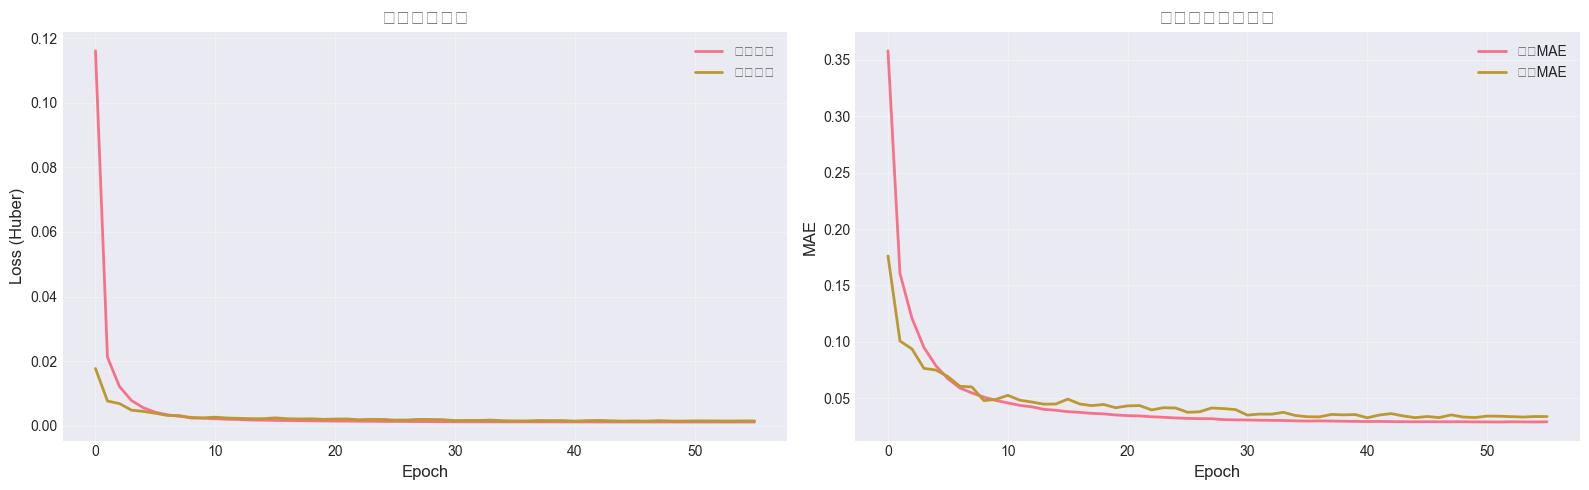

最终训练损失: 0.0011
最终验证损失: 0.0015
最终训练MAE:  0.0291
最终验证MAE:  0.0338


In [32]:
# 可视化训练历史
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 损失曲线
axes[0].plot(history.history['loss'], label='训练损失', linewidth=2)
axes[0].plot(history.history['val_loss'], label='验证损失', linewidth=2)
axes[0].set_title('模型损失曲线', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (Huber)', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# MAE曲线
axes[1].plot(history.history['mae'], label='训练MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='验证MAE', linewidth=2)
axes[1].set_title('平均绝对误差曲线', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"最终训练损失: {history.history['loss'][-1]:.4f}")
print(f"最终验证损失: {history.history['val_loss'][-1]:.4f}")
print(f"最终训练MAE:  {history.history['mae'][-1]:.4f}")
print(f"最终验证MAE:  {history.history['val_mae'][-1]:.4f}")

## 7. 模型评估

In [33]:
# 预测
y_pred = model.predict(X_test, verbose=0)

# 反标准化
temp_pred = np.zeros((y_pred.shape[0], y_pred.shape[1], data.shape[1]))
temp_pred[:, :, 0] = y_pred
temp_pred = temp_pred.reshape(-1, data.shape[1])
y_pred_rescaled = scaler.inverse_transform(temp_pred)[:, 0].reshape(y_pred.shape)

temp_true = np.zeros((y_test.shape[0], y_test.shape[1], data.shape[1]))
temp_true[:, :, 0] = y_test
temp_true = temp_true.reshape(-1, data.shape[1])
y_true_rescaled = scaler.inverse_transform(temp_true)[:, 0].reshape(y_test.shape)

# 计算评估指标
mse = mean_squared_error(y_true_rescaled.flatten(), y_pred_rescaled.flatten())
mae = mean_absolute_error(y_true_rescaled.flatten(), y_pred_rescaled.flatten())
rmse = np.sqrt(mse)
r2 = r2_score(y_true_rescaled.flatten(), y_pred_rescaled.flatten())
mape = np.mean(np.abs((y_true_rescaled.flatten() - y_pred_rescaled.flatten()) / 
                      np.maximum(y_true_rescaled.flatten(), 1))) * 100

print("="*60)
print("整体评估指标:")
print("="*60)
print(f"  MSE (均方误差):              {mse:.2f}")
print(f"  RMSE (均方根误差):           {rmse:.2f}")
print(f"  MAE (平均绝对误差):          {mae:.2f}")
print(f"  MAPE (平均绝对百分比误差):   {mape:.2f}%")
print(f"  R² (决定系数):               {r2:.4f}")
print("="*60)

# 按预测天数分别评估
print("\n按预测天数评估:")
print("-"*60)
for day in range(forecast_days):
    day_mse = mean_squared_error(y_true_rescaled[:, day], y_pred_rescaled[:, day])
    day_mae = mean_absolute_error(y_true_rescaled[:, day], y_pred_rescaled[:, day])
    day_rmse = np.sqrt(day_mse)
    day_r2 = r2_score(y_true_rescaled[:, day], y_pred_rescaled[:, day])
    print(f"  第 {day+1} 天: RMSE={day_rmse:6.2f}, MAE={day_mae:6.2f}, R²={day_r2:.4f}")
print("-"*60)

整体评估指标:
  MSE (均方误差):              4894.23
  RMSE (均方根误差):           69.96
  MAE (平均绝对误差):          43.15
  MAPE (平均绝对百分比误差):   7.38%
  R² (决定系数):               0.0534

按预测天数评估:
------------------------------------------------------------
  第 1 天: RMSE= 71.17, MAE= 44.10, R²=0.0253
  第 2 天: RMSE= 70.06, MAE= 43.27, R²=0.0533
  第 3 天: RMSE= 68.36, MAE= 42.12, R²=0.0974
  第 4 天: RMSE= 70.04, MAE= 43.23, R²=0.0505
  第 5 天: RMSE= 70.85, MAE= 43.76, R²=0.0272
  第 6 天: RMSE= 68.29, MAE= 41.96, R²=0.0951
  第 7 天: RMSE= 70.87, MAE= 43.64, R²=0.0247
------------------------------------------------------------


## 8. 预测结果可视化

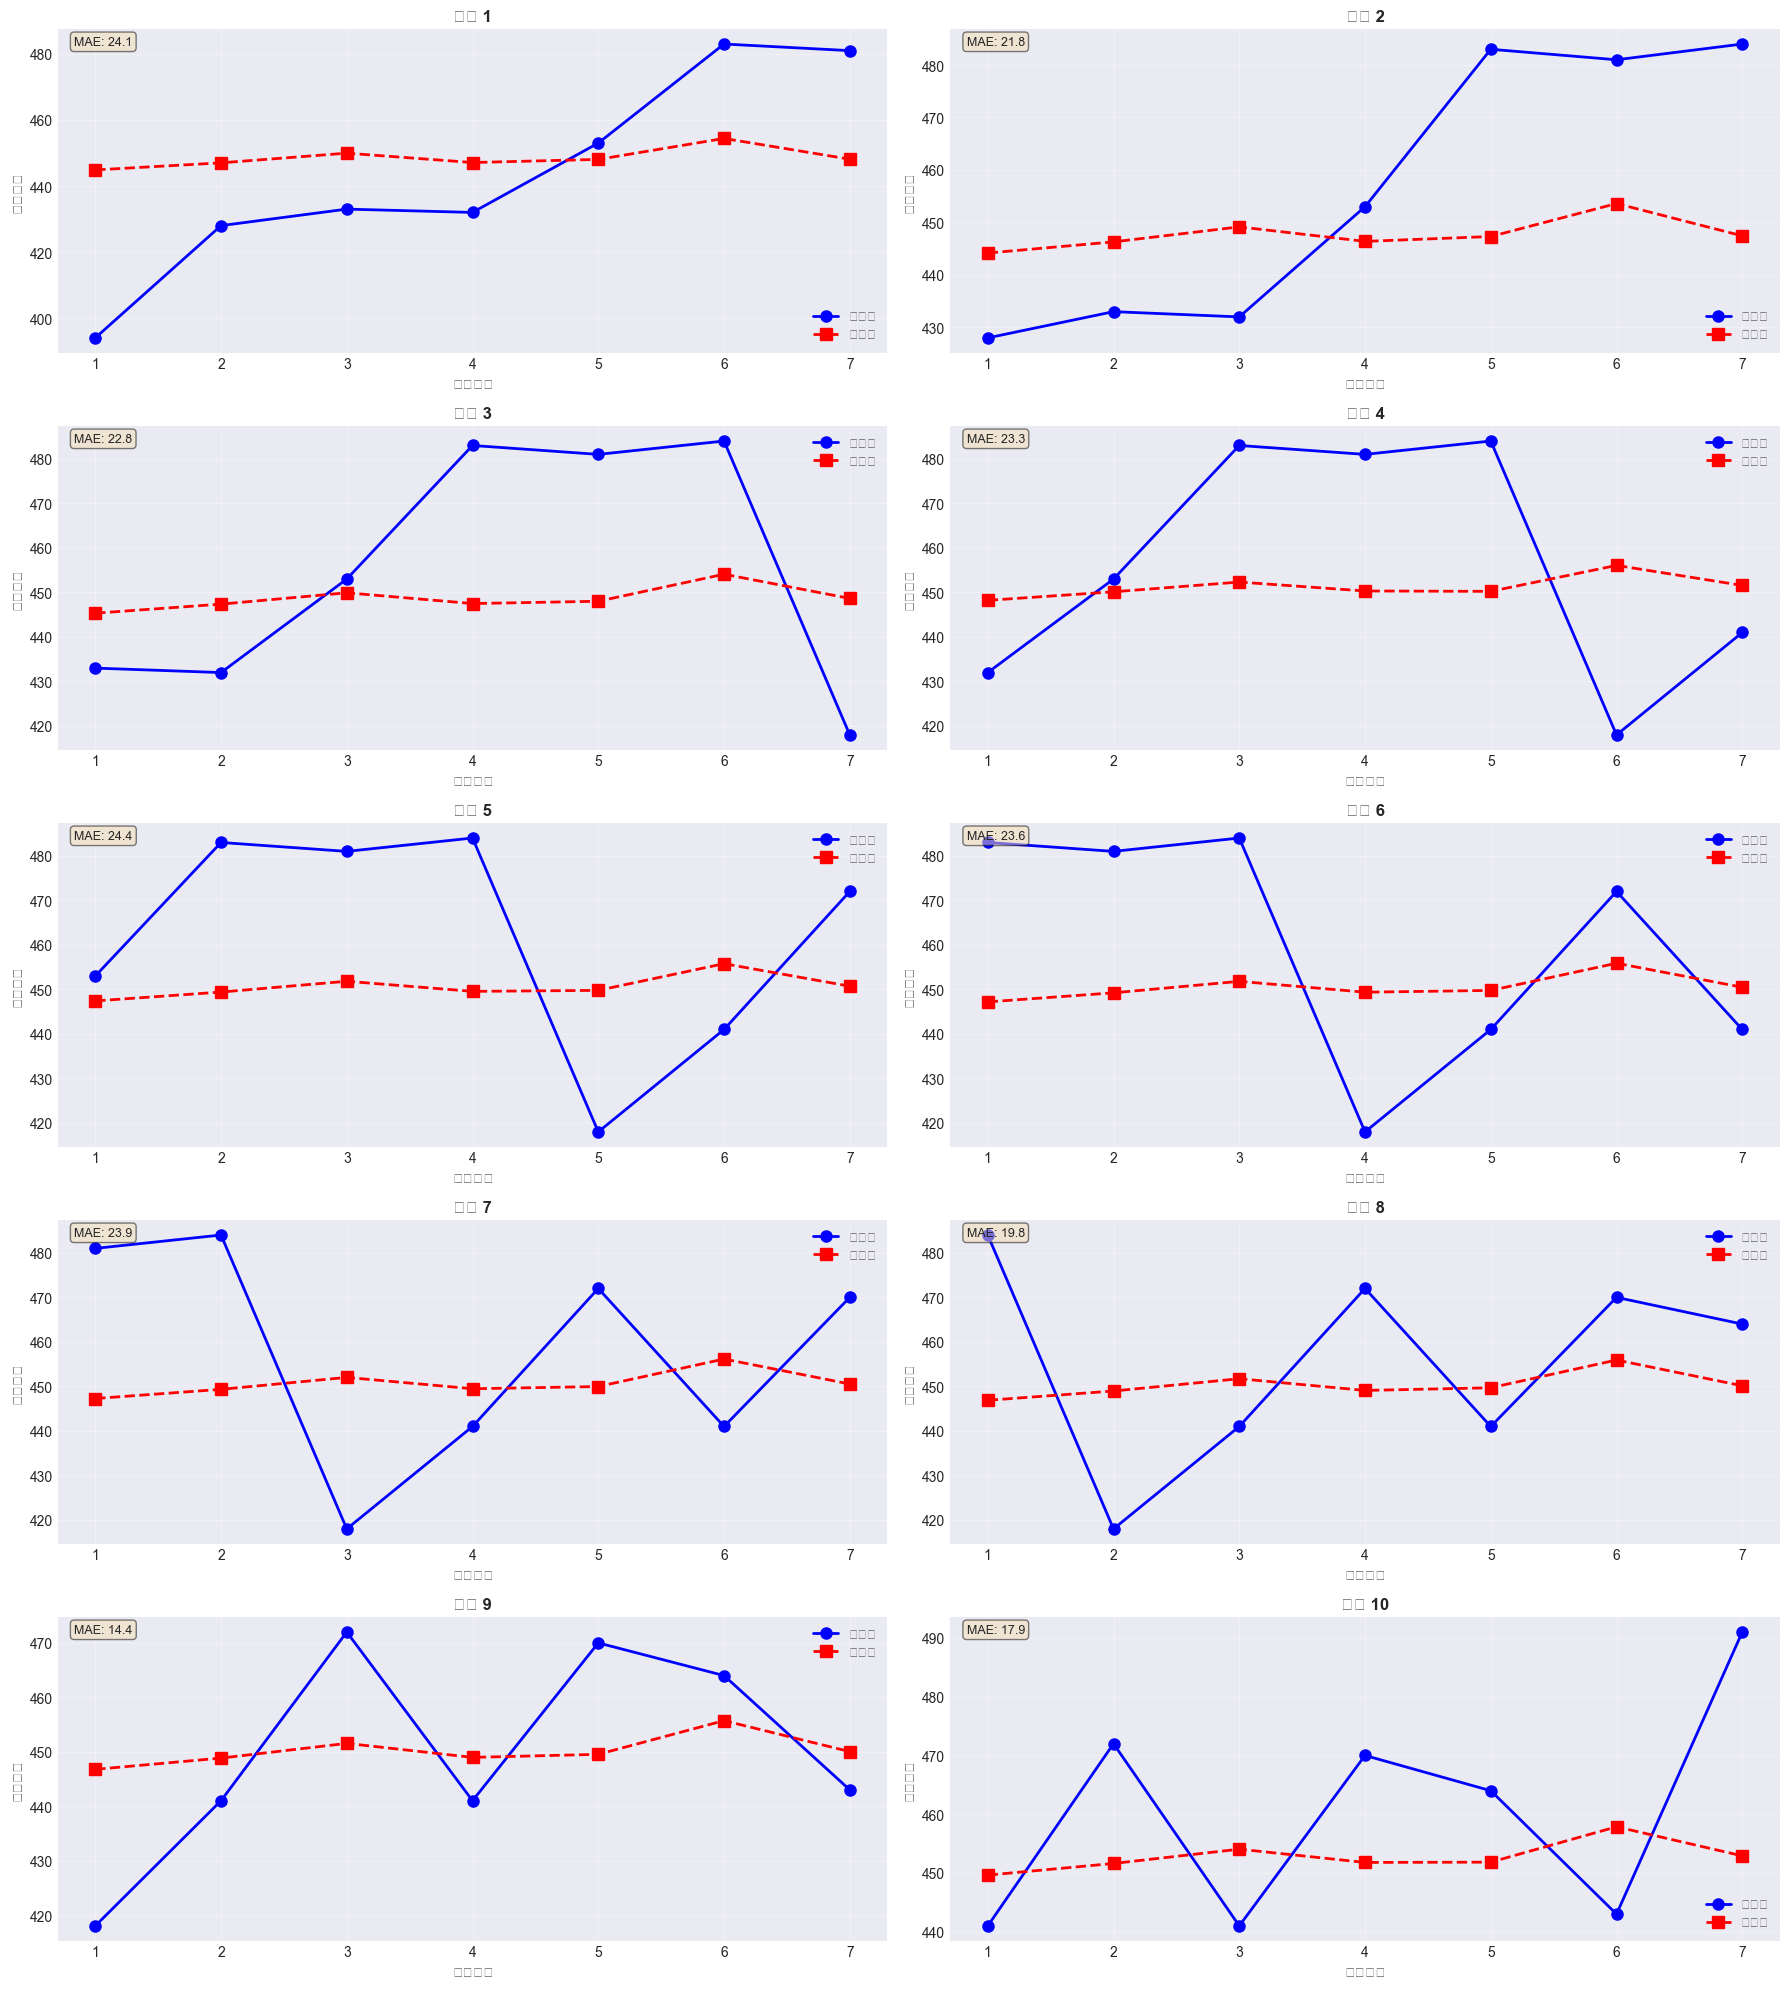


前10个测试样本的详细预测结果:

样本 1:
  真实值: [394. 428. 433. 432. 453. 483. 481.]
  预测值: [444.9 447.  449.9 447.1 448.1 454.4 448.1]
  误差:   [-50.9 -19.  -16.9 -15.1   4.9  28.6  32.9]
  MAE:    24.05

样本 2:
  真实值: [428. 433. 432. 453. 483. 481. 484.]
  预测值: [444.2 446.3 449.2 446.4 447.3 453.6 447.4]
  误差:   [-16.2 -13.3 -17.2   6.6  35.7  27.4  36.6]
  MAE:    21.84

样本 3:
  真实值: [433. 432. 453. 483. 481. 484. 418.]
  预测值: [445.3 447.4 449.9 447.5 448.  454.1 448.7]
  误差:   [-12.3 -15.4   3.1  35.5  33.   29.9 -30.7]
  MAE:    22.83

样本 4:
  真实值: [432. 453. 483. 481. 484. 418. 441.]
  预测值: [448.2 450.1 452.3 450.3 450.2 456.1 451.6]
  误差:   [-16.2   2.9  30.7  30.7  33.8 -38.1 -10.6]
  MAE:    23.26

样本 5:
  真实值: [453. 483. 481. 484. 418. 441. 472.]
  预测值: [447.4 449.4 451.8 449.6 449.8 455.8 450.7]
  误差:   [  5.6  33.6  29.2  34.4 -31.8 -14.8  21.3]
  MAE:    24.38

样本 6:
  真实值: [483. 481. 484. 418. 441. 472. 441.]
  预测值: [447.2 449.2 451.8 449.4 449.8 455.9 450.5]
  误差:   [ 35.8  31.8  32.2 -31

In [34]:
# 可视化前10个测试样本的预测结果
n_samples = min(10, len(y_test))
fig, axes = plt.subplots(5, 2, figsize=(18, 20))
axes = axes.flatten()

for i in range(n_samples):
    axes[i].plot(range(1, forecast_days+1), y_true_rescaled[i], 
                 'o-', label='真实值', linewidth=2, markersize=8, color='blue')
    axes[i].plot(range(1, forecast_days+1), y_pred_rescaled[i], 
                 's--', label='预测值', linewidth=2, markersize=8, color='red')
    axes[i].set_title(f'样本 {i+1}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('预测天数', fontsize=10)
    axes[i].set_ylabel('犯罪数量', fontsize=10)
    axes[i].legend(fontsize=9)
    axes[i].grid(True, alpha=0.3)
    
    # 添加误差信息
    mae_sample = mean_absolute_error(y_true_rescaled[i], y_pred_rescaled[i])
    axes[i].text(0.02, 0.98, f'MAE: {mae_sample:.1f}', 
                 transform=axes[i].transAxes, fontsize=9,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# 打印详细预测结果
print("\n" + "="*80)
print("前10个测试样本的详细预测结果:")
print("="*80)
for i in range(n_samples):
    print(f"\n样本 {i+1}:")
    print(f"  真实值: {y_true_rescaled[i].round(1)}")
    print(f"  预测值: {y_pred_rescaled[i].round(1)}")
    print(f"  误差:   {(y_true_rescaled[i] - y_pred_rescaled[i]).round(1)}")
    print(f"  MAE:    {mean_absolute_error(y_true_rescaled[i], y_pred_rescaled[i]):.2f}")

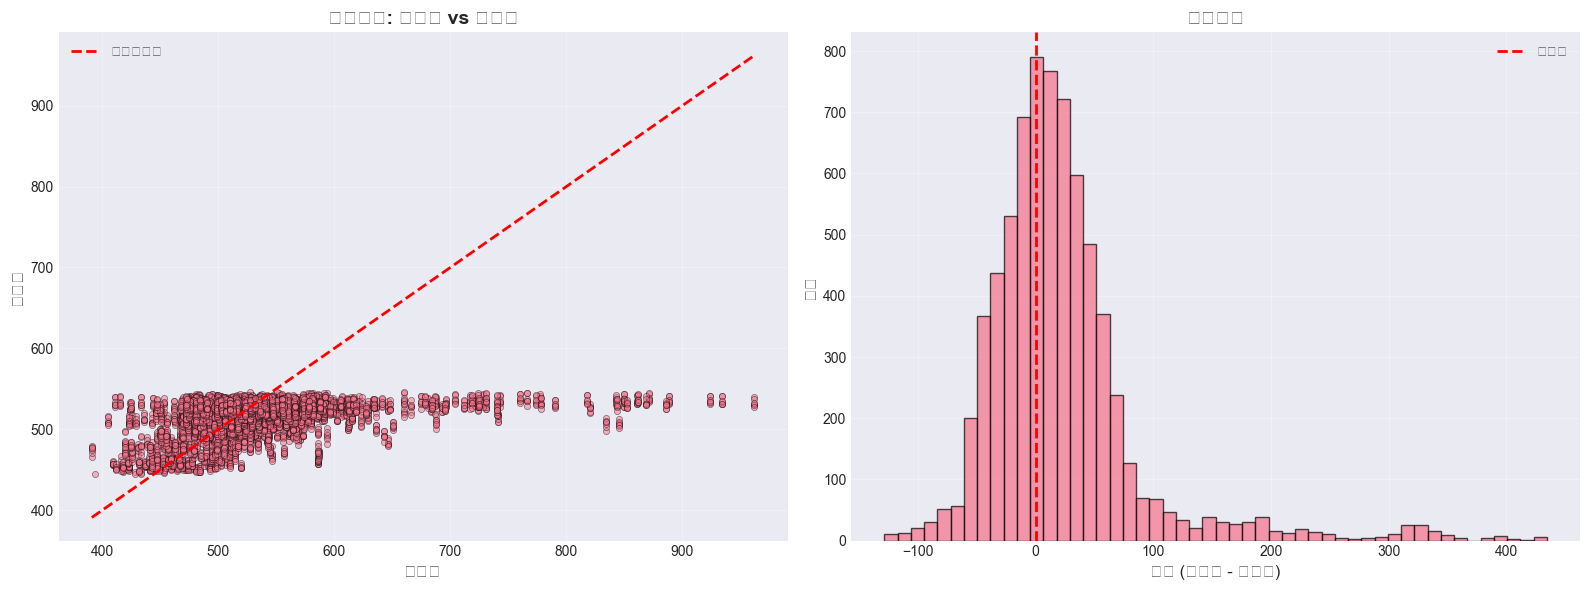


残差统计:
  均值: 21.98
  标准差: 66.42
  中位数: 11.75


In [35]:
# 散点图：真实值 vs 预测值
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 所有预测的散点图
axes[0].scatter(y_true_rescaled.flatten(), y_pred_rescaled.flatten(), 
                alpha=0.5, s=20, edgecolors='k', linewidth=0.5)
axes[0].plot([y_true_rescaled.min(), y_true_rescaled.max()], 
             [y_true_rescaled.min(), y_true_rescaled.max()], 
             'r--', linewidth=2, label='完美预测线')
axes[0].set_title('所有预测: 真实值 vs 预测值', fontsize=14, fontweight='bold')
axes[0].set_xlabel('真实值', fontsize=12)
axes[0].set_ylabel('预测值', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# 残差分布
residuals = (y_true_rescaled - y_pred_rescaled).flatten()
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='零残差')
axes[1].set_title('残差分布', fontsize=14, fontweight='bold')
axes[1].set_xlabel('残差 (真实值 - 预测值)', fontsize=12)
axes[1].set_ylabel('频数', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n残差统计:")
print(f"  均值: {residuals.mean():.2f}")
print(f"  标准差: {residuals.std():.2f}")
print(f"  中位数: {np.median(residuals):.2f}")

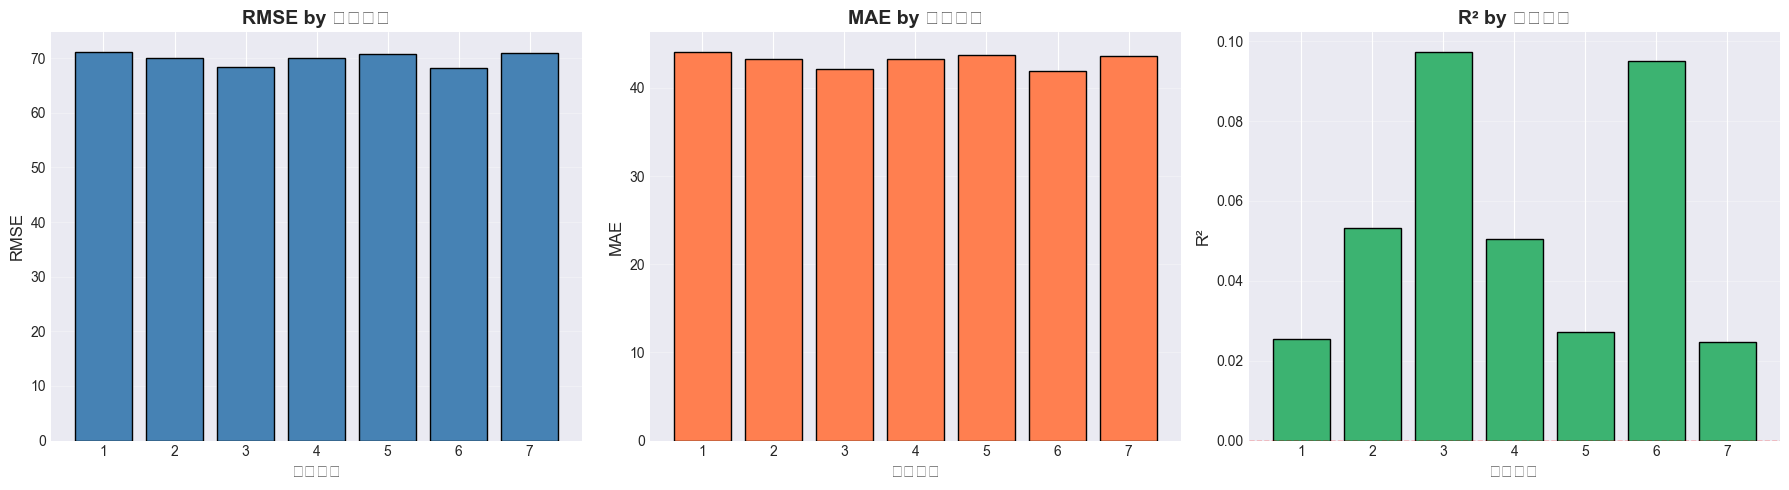


每天的预测性能:
 Day      RMSE       MAE       R2
   1 71.173018 44.097910 0.025344
   2 70.063046 43.272277 0.053294
   3 68.362310 42.123389 0.097364
   4 70.041884 43.227248 0.050516
   5 70.849601 43.760760 0.027229
   6 68.286160 41.957849 0.095126
   7 70.874979 43.641817 0.024700


In [36]:
# 按预测天数的性能可视化
day_metrics = []
for day in range(forecast_days):
    day_rmse = np.sqrt(mean_squared_error(y_true_rescaled[:, day], y_pred_rescaled[:, day]))
    day_mae = mean_absolute_error(y_true_rescaled[:, day], y_pred_rescaled[:, day])
    day_r2 = r2_score(y_true_rescaled[:, day], y_pred_rescaled[:, day])
    day_metrics.append({'Day': day+1, 'RMSE': day_rmse, 'MAE': day_mae, 'R2': day_r2})

metrics_df = pd.DataFrame(day_metrics)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE by day
axes[0].bar(metrics_df['Day'], metrics_df['RMSE'], color='steelblue', edgecolor='black')
axes[0].set_title('RMSE by 预测天数', fontsize=14, fontweight='bold')
axes[0].set_xlabel('预测天数', fontsize=12)
axes[0].set_ylabel('RMSE', fontsize=12)
axes[0].grid(True, alpha=0.3, axis='y')

# MAE by day
axes[1].bar(metrics_df['Day'], metrics_df['MAE'], color='coral', edgecolor='black')
axes[1].set_title('MAE by 预测天数', fontsize=14, fontweight='bold')
axes[1].set_xlabel('预测天数', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

# R² by day
axes[2].bar(metrics_df['Day'], metrics_df['R2'], color='mediumseagreen', edgecolor='black')
axes[2].set_title('R² by 预测天数', fontsize=14, fontweight='bold')
axes[2].set_xlabel('预测天数', fontsize=12)
axes[2].set_ylabel('R²', fontsize=12)
axes[2].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n每天的预测性能:")
print(metrics_df.to_string(index=False))

## 9. 模型总结

In [37]:
print("=" * 80)
print("基础LSTM犯罪预测模型 - 最终总结")
print("=" * 80)

print(f"\n📊 数据处理:")
print(f"  ├─ 时间范围: 2010-2023 (14年)")
print(f"  ├─ 总天数: {len(daily_crimes)} 天")
print(f"  ├─ 异常值修正: {jan_1st_anomaly + month_end_anomaly + outlier_count} 个")
print(f"  └─ 特征数量: {len(feature_columns)}")

print(f"\n🏗️  模型配置:")
print(f"  ├─ 模型类型: 3层LSTM + BatchNorm + Dropout")
print(f"  ├─ 回溯窗口: {lookback_days} 天")
print(f"  ├─ 预测窗口: {forecast_days} 天")
print(f"  ├─ 训练样本: {len(X_train)}")
print(f"  ├─ 测试样本: {len(X_test)}")
print(f"  ├─ 损失函数: Huber (对异常值鲁棒)")
print(f"  └─ 训练轮数: {len(history.history['loss'])}")

print(f"\n📈 性能指标:")
print(f"  ├─ RMSE: {rmse:.2f}")
print(f"  ├─ MAE:  {mae:.2f}")
print(f"  ├─ R²:   {r2:.4f}")
print(f"  └─ MAPE: {mape:.2f}%")

print(f"\n✨ 主要改进:")
print(f"  ✓ 修正1月1日数据录入异常")
print(f"  ✓ 修正月末数据异常峰值")
print(f"  ✓ 平滑其他异常尖峰 (3σ准则)")
print(f"  ✓ 使用Huber损失函数")
print(f"  ✓ BatchNormalization加速收敛")
print(f"  ✓ 多层Dropout防止过拟合")

print("\n" + "=" * 80)
print("✅ 模型构建完成!")
print("=" * 80)

基础LSTM犯罪预测模型 - 最终总结

📊 数据处理:
  ├─ 时间范围: 2010-2023 (14年)
  ├─ 总天数: 5113 天
  ├─ 异常值修正: 3 个
  └─ 特征数量: 12

🏗️  模型配置:
  ├─ 模型类型: 3层LSTM + BatchNorm + Dropout
  ├─ 回溯窗口: 30 天
  ├─ 预测窗口: 7 天
  ├─ 训练样本: 4060
  ├─ 测试样本: 1016
  ├─ 损失函数: Huber (对异常值鲁棒)
  └─ 训练轮数: 56

📈 性能指标:
  ├─ RMSE: 69.96
  ├─ MAE:  43.15
  ├─ R²:   0.0534
  └─ MAPE: 7.38%

✨ 主要改进:
  ✓ 修正1月1日数据录入异常
  ✓ 修正月末数据异常峰值
  ✓ 平滑其他异常尖峰 (3σ准则)
  ✓ 使用Huber损失函数
  ✓ BatchNormalization加速收敛
  ✓ 多层Dropout防止过拟合

✅ 模型构建完成!


## 10. 后80%数据的整体预测情况分析

检查模型是否过拟合或只是预测均值

In [38]:
# 对整个数据集（包括训练集和测试集）进行预测
print("=" * 80)
print("后80%数据（训练集+测试集）的整体预测分析")
print("=" * 80)

# 重新生成完整的X和y（用于预测）
X_all = np.concatenate([X_train, X_test], axis=0)
y_all = np.concatenate([y_train, y_test], axis=0)

# 对所有数据进行预测
print("\n正在预测所有数据...")
y_pred_all = model.predict(X_all, verbose=0)

# 反标准化
temp_pred_all = np.zeros((y_pred_all.shape[0], y_pred_all.shape[1], data.shape[1]))
temp_pred_all[:, :, 0] = y_pred_all
temp_pred_all = temp_pred_all.reshape(-1, data.shape[1])
y_pred_all_rescaled = scaler.inverse_transform(temp_pred_all)[:, 0].reshape(y_pred_all.shape)

temp_true_all = np.zeros((y_all.shape[0], y_all.shape[1], data.shape[1]))
temp_true_all[:, :, 0] = y_all
temp_true_all = temp_true_all.reshape(-1, data.shape[1])
y_true_all_rescaled = scaler.inverse_transform(temp_true_all)[:, 0].reshape(y_all.shape)

# 只取第1天的预测（最简单的情况）
y_true_day1 = y_true_all_rescaled[:, 0]
y_pred_day1 = y_pred_all_rescaled[:, 0]

print(f"\n数据统计 (第1天预测):")
print("-" * 80)
print(f"{'统计量':<20} {'真实值':<20} {'预测值':<20} {'差异':<20}")
print("-" * 80)
print(f"{'平均值':<20} {y_true_day1.mean():<20.2f} {y_pred_day1.mean():<20.2f} {abs(y_true_day1.mean() - y_pred_day1.mean()):<20.2f}")
print(f"{'标准差':<20} {y_true_day1.std():<20.2f} {y_pred_day1.std():<20.2f} {abs(y_true_day1.std() - y_pred_day1.std()):<20.2f}")
print(f"{'最小值':<20} {y_true_day1.min():<20.2f} {y_pred_day1.min():<20.2f} {abs(y_true_day1.min() - y_pred_day1.min()):<20.2f}")
print(f"{'最大值':<20} {y_true_day1.max():<20.2f} {y_pred_day1.max():<20.2f} {abs(y_true_day1.max() - y_pred_day1.max()):<20.2f}")
print(f"{'中位数':<20} {np.median(y_true_day1):<20.2f} {np.median(y_pred_day1):<20.2f} {abs(np.median(y_true_day1) - np.median(y_pred_day1)):<20.2f}")
print("-" * 80)

# 分析预测值的分布
pred_range = y_pred_day1.max() - y_pred_day1.min()
true_range = y_true_day1.max() - y_true_day1.min()
range_ratio = pred_range / true_range if true_range > 0 else 0

print(f"\n🔍 预测值分布分析:")
print(f"  真实值范围: {true_range:.2f} (从 {y_true_day1.min():.0f} 到 {y_true_day1.max():.0f})")
print(f"  预测值范围: {pred_range:.2f} (从 {y_pred_day1.min():.0f} 到 {y_pred_day1.max():.0f})")
print(f"  范围比例: {range_ratio:.2%}")

if range_ratio < 0.3:
    print(f"  ⚠️  警告: 预测值范围仅为真实值的 {range_ratio:.1%}，模型可能过于保守，倾向预测均值！")
elif range_ratio < 0.6:
    print(f"  ⚠️  注意: 预测值范围为真实值的 {range_ratio:.1%}，模型预测变化较小")
else:
    print(f"  ✅ 预测值范围合理 ({range_ratio:.1%})")

# 检查预测值是否过于集中
pred_q25, pred_q75 = np.percentile(y_pred_day1, [25, 75])
true_q25, true_q75 = np.percentile(y_true_day1, [25, 75])
pred_iqr = pred_q75 - pred_q25
true_iqr = true_q75 - true_q25
iqr_ratio = pred_iqr / true_iqr if true_iqr > 0 else 0

print(f"\n  四分位距 (IQR):")
print(f"    真实值 IQR: {true_iqr:.2f}")
print(f"    预测值 IQR: {pred_iqr:.2f}")
print(f"    IQR 比例: {iqr_ratio:.2%}")

if iqr_ratio < 0.4:
    print(f"    ⚠️  警告: 预测值过于集中，50%的数据只分布在 {pred_iqr:.0f} 的范围内！")
elif iqr_ratio < 0.7:
    print(f"    ⚠️  注意: 预测值较为集中")
else:
    print(f"    ✅ 预测值分布合理")

# 计算预测值与均值的关系
pred_mean = y_pred_day1.mean()
pred_close_to_mean = np.sum(np.abs(y_pred_day1 - pred_mean) < 20)  # 距离均值20以内
pred_close_to_mean_ratio = pred_close_to_mean / len(y_pred_day1)

print(f"\n  预测值与均值的关系:")
print(f"    预测均值: {pred_mean:.2f}")
print(f"    距离均值20以内的预测: {pred_close_to_mean}/{len(y_pred_day1)} ({pred_close_to_mean_ratio:.1%})")

if pred_close_to_mean_ratio > 0.7:
    print(f"    ⚠️  严重警告: {pred_close_to_mean_ratio:.0%}的预测值都集中在均值附近，模型基本在预测均值！")
elif pred_close_to_mean_ratio > 0.5:
    print(f"    ⚠️  警告: {pred_close_to_mean_ratio:.0%}的预测值集中在均值附近")
else:
    print(f"    ✅ 预测值分布较为分散")

print("\n" + "=" * 80)

后80%数据（训练集+测试集）的整体预测分析

正在预测所有数据...

数据统计 (第1天预测):
--------------------------------------------------------------------------------
统计量                  真实值                  预测值                  差异                  
--------------------------------------------------------------------------------
平均值                  497.52               486.92               10.61               
标准差                  73.91                36.32                37.60               
最小值                  117.00               434.28               317.28              
最大值                  1436.00              546.54               889.46              
中位数                  490.00               483.08               6.92                
--------------------------------------------------------------------------------

🔍 预测值分布分析:
  真实值范围: 1319.00 (从 117 到 1436)
  预测值范围: 112.25 (从 434 到 547)
  范围比例: 8.51%
  ⚠️  警告: 预测值范围仅为真实值的 8.5%，模型可能过于保守，倾向预测均值！

  四分位距 (IQR):
    真实值 IQR: 78.00
    预测值 IQR: 73.02
    IQR 比例: 93.62

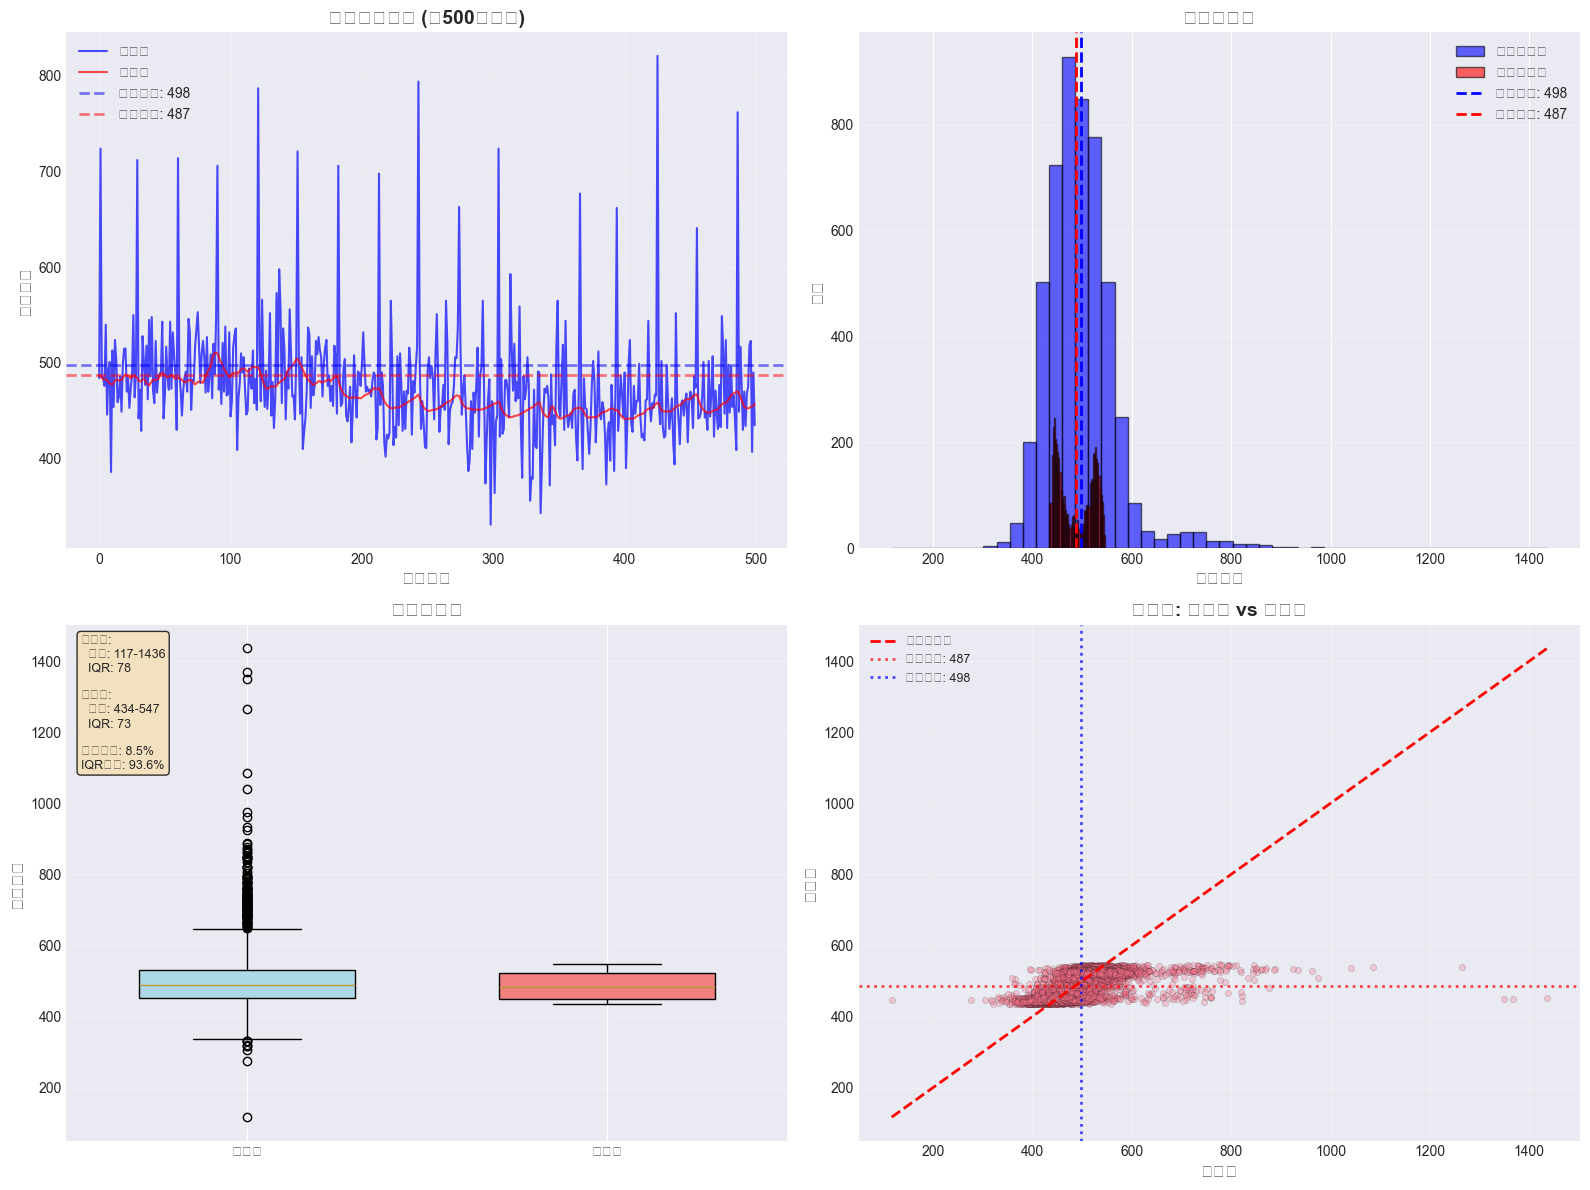


📊 图表说明:
  • 左上: 时间序列对比 - 观察预测值是否跟随真实值的变化
  • 右上: 分布直方图 - 比较预测值和真实值的分布范围
  • 左下: 箱线图 - 直观对比数据的离散程度
  • 右下: 散点图 - 如果点集中在均值线附近，说明模型在预测均值


In [39]:
# 可视化：真实值vs预测值的分布对比
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 时间序列对比（只显示部分数据以便看清）
sample_size = min(500, len(y_true_day1))
axes[0, 0].plot(range(sample_size), y_true_day1[:sample_size], 
                label='真实值', alpha=0.7, linewidth=1.5, color='blue')
axes[0, 0].plot(range(sample_size), y_pred_day1[:sample_size], 
                label='预测值', alpha=0.7, linewidth=1.5, color='red')
axes[0, 0].axhline(y=y_true_day1.mean(), color='blue', linestyle='--', 
                   linewidth=2, alpha=0.5, label=f'真实均值: {y_true_day1.mean():.0f}')
axes[0, 0].axhline(y=y_pred_day1.mean(), color='red', linestyle='--', 
                   linewidth=2, alpha=0.5, label=f'预测均值: {y_pred_day1.mean():.0f}')
axes[0, 0].set_title(f'时间序列对比 (前{sample_size}个样本)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('样本索引', fontsize=12)
axes[0, 0].set_ylabel('犯罪数量', fontsize=12)
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# 2. 分布直方图对比
axes[0, 1].hist(y_true_day1, bins=50, alpha=0.6, label='真实值分布', 
                color='blue', edgecolor='black')
axes[0, 1].hist(y_pred_day1, bins=50, alpha=0.6, label='预测值分布', 
                color='red', edgecolor='black')
axes[0, 1].axvline(x=y_true_day1.mean(), color='blue', linestyle='--', 
                   linewidth=2, label=f'真实均值: {y_true_day1.mean():.0f}')
axes[0, 1].axvline(x=y_pred_day1.mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'预测均值: {y_pred_day1.mean():.0f}')
axes[0, 1].set_title('值分布对比', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('犯罪数量', fontsize=12)
axes[0, 1].set_ylabel('频数', fontsize=12)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. 箱线图对比
box_data = [y_true_day1, y_pred_day1]
bp = axes[1, 0].boxplot(box_data, labels=['真实值', '预测值'], 
                        patch_artist=True, widths=0.6)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
axes[1, 0].set_title('箱线图对比', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('犯罪数量', fontsize=12)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 添加统计信息
stats_text = f'真实值:\n  范围: {y_true_day1.min():.0f}-{y_true_day1.max():.0f}\n  IQR: {true_iqr:.0f}\n\n'
stats_text += f'预测值:\n  范围: {y_pred_day1.min():.0f}-{y_pred_day1.max():.0f}\n  IQR: {pred_iqr:.0f}\n\n'
stats_text += f'范围比例: {range_ratio:.1%}\nIQR比例: {iqr_ratio:.1%}'
axes[1, 0].text(0.02, 0.98, stats_text, transform=axes[1, 0].transAxes, 
                fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 4. 散点图：预测值 vs 真实值
axes[1, 1].scatter(y_true_day1, y_pred_day1, alpha=0.3, s=20, edgecolors='k', linewidth=0.3)
axes[1, 1].plot([y_true_day1.min(), y_true_day1.max()], 
                [y_true_day1.min(), y_true_day1.max()], 
                'r--', linewidth=2, label='完美预测线')
# 添加均值线
axes[1, 1].axhline(y=y_pred_day1.mean(), color='red', linestyle=':', 
                   linewidth=2, alpha=0.7, label=f'预测均值: {y_pred_day1.mean():.0f}')
axes[1, 1].axvline(x=y_true_day1.mean(), color='blue', linestyle=':', 
                   linewidth=2, alpha=0.7, label=f'真实均值: {y_true_day1.mean():.0f}')
axes[1, 1].set_title('散点图: 真实值 vs 预测值', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('真实值', fontsize=12)
axes[1, 1].set_ylabel('预测值', fontsize=12)
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 图表说明:")
print("  • 左上: 时间序列对比 - 观察预测值是否跟随真实值的变化")
print("  • 右上: 分布直方图 - 比较预测值和真实值的分布范围")
print("  • 左下: 箱线图 - 直观对比数据的离散程度")
print("  • 右下: 散点图 - 如果点集中在均值线附近，说明模型在预测均值")

In [40]:
# 最终诊断
print("\n" + "=" * 80)
print("🔬 模型诊断总结")
print("=" * 80)

# 检查指标
checks = []

# 1. 检查范围比例
if range_ratio < 0.3:
    checks.append(("❌ 预测范围过小", f"仅为真实值的 {range_ratio:.1%}"))
elif range_ratio < 0.6:
    checks.append(("⚠️  预测范围偏小", f"为真实值的 {range_ratio:.1%}"))
else:
    checks.append(("✅ 预测范围合理", f"为真实值的 {range_ratio:.1%}"))

# 2. 检查IQR比例
if iqr_ratio < 0.4:
    checks.append(("❌ 预测值过于集中", f"IQR仅为真实值的 {iqr_ratio:.1%}"))
elif iqr_ratio < 0.7:
    checks.append(("⚠️  预测值较为集中", f"IQR为真实值的 {iqr_ratio:.1%}"))
else:
    checks.append(("✅ 预测值分散度合理", f"IQR为真实值的 {iqr_ratio:.1%}"))

# 3. 检查预测值标准差
std_ratio = y_pred_day1.std() / y_true_day1.std()
if std_ratio < 0.3:
    checks.append(("❌ 预测标准差过小", f"仅为真实值的 {std_ratio:.1%}"))
elif std_ratio < 0.6:
    checks.append(("⚠️  预测标准差偏小", f"为真实值的 {std_ratio:.1%}"))
else:
    checks.append(("✅ 预测标准差合理", f"为真实值的 {std_ratio:.1%}"))

# 4. 检查R²
if r2 < 0.3:
    checks.append(("❌ R²过低", f"R² = {r2:.3f}"))
elif r2 < 0.6:
    checks.append(("⚠️  R²偏低", f"R² = {r2:.3f}"))
else:
    checks.append(("✅ R²合理", f"R² = {r2:.3f}"))

# 5. 检查均值集中度
if pred_close_to_mean_ratio > 0.7:
    checks.append(("❌ 预测过于集中均值", f"{pred_close_to_mean_ratio:.0%}集中在均值附近"))
elif pred_close_to_mean_ratio > 0.5:
    checks.append(("⚠️  预测较为集中均值", f"{pred_close_to_mean_ratio:.0%}集中在均值附近"))
else:
    checks.append(("✅ 预测值分布合理", f"{pred_close_to_mean_ratio:.0%}集中在均值附近"))

# 打印所有检查结果
for check, detail in checks:
    print(f"\n  {check}")
    print(f"    └─ {detail}")

# 总体评估
fail_count = sum(1 for check, _ in checks if "❌" in check)
warn_count = sum(1 for check, _ in checks if "⚠️" in check)

print("\n" + "-" * 80)
if fail_count >= 3:
    print("❌ 总体评估: 模型存在严重问题，很可能在预测均值或过拟合")
    print("\n💡 建议:")
    print("  1. 减少模型复杂度（减少LSTM层数或单元数）")
    print("  2. 增加正则化（增大Dropout比例）")
    print("  3. 减少特征数量（可能特征噪音过大）")
    print("  4. 尝试更简单的模型（如简单的LSTM或传统时间序列模型）")
    print("  5. 检查数据质量，可能异常值处理过度导致数据变化太小")
elif fail_count >= 1 or warn_count >= 3:
    print("⚠️  总体评估: 模型表现不佳，预测能力有限")
    print("\n💡 建议:")
    print("  1. 调整学习率")
    print("  2. 调整Dropout比例")
    print("  3. 尝试不同的lookback窗口大小")
    print("  4. 考虑增加更多有效特征")
else:
    print("✅ 总体评估: 模型表现尚可")
    
print("=" * 80)


🔬 模型诊断总结

  ❌ 预测范围过小
    └─ 仅为真实值的 8.5%

  ✅ 预测值分散度合理
    └─ IQR为真实值的 93.6%

  ⚠️  预测标准差偏小
    └─ 为真实值的 49.1%

  ❌ R²过低
    └─ R² = 0.053

  ✅ 预测值分布合理
    └─ 17%集中在均值附近

--------------------------------------------------------------------------------
⚠️  总体评估: 模型表现不佳，预测能力有限

💡 建议:
  1. 调整学习率
  2. 调整Dropout比例
  3. 尝试不同的lookback窗口大小
  4. 考虑增加更多有效特征


## 11. 改进模型 - 解决预测均值问题

根据诊断结果，模型存在严重的预测能力不足问题。尝试以下改进：
1. **简化模型** - 减少复杂度，防止过拟合
2. **减少Dropout** - 可能dropout过大导致信息丢失
3. **调整学习率** - 提高学习率以更好地学习变化
4. **减少特征** - 只保留最重要的特征，减少噪音
5. **使用MSE损失** - Huber损失可能过于保守

In [41]:
# 改进1: 只使用最重要的特征（减少噪音）
print("=" * 80)
print("改进版模型 - 特征选择")
print("=" * 80)

# 只保留最核心的特征
important_features = ['crime_count', 'dayofweek', 'month', 'is_weekend', 
                      'rolling_mean_7', 'rolling_mean_30']

data_improved = daily_crimes[important_features].values
print(f"\n特征数量: 从 {len(feature_columns)} 减少到 {len(important_features)}")
print(f"保留特征: {important_features}")

# 重新标准化
scaler_improved = MinMaxScaler()
scaled_data_improved = scaler_improved.fit_transform(data_improved)

# 创建序列数据
X_improved, y_improved = [], []
for i in range(lookback_days, len(scaled_data_improved) - forecast_days):
    X_improved.append(scaled_data_improved[i-lookback_days:i])
    y_improved.append(scaled_data_improved[i:i+forecast_days, 0])  # crime_count是第0列

X_improved = np.array(X_improved)
y_improved = np.array(y_improved)

# 划分训练集和测试集
split_index_improved = int(len(X_improved) * 0.8)
X_train_improved, X_test_improved = X_improved[:split_index_improved], X_improved[split_index_improved:]
y_train_improved, y_test_improved = y_improved[:split_index_improved], y_improved[split_index_improved:]

print(f"\n数据准备:")
print(f"  训练集: {X_train_improved.shape[0]} 个样本")
print(f"  测试集: {X_test_improved.shape[0]} 个样本")
print(f"  输入形状: {X_train_improved.shape[1:]} (时间步, 特征数)")

改进版模型 - 特征选择

特征数量: 从 12 减少到 6
保留特征: ['crime_count', 'dayofweek', 'month', 'is_weekend', 'rolling_mean_7', 'rolling_mean_30']

数据准备:
  训练集: 4060 个样本
  测试集: 1016 个样本
  输入形状: (30, 6) (时间步, 特征数)


In [42]:
# 改进2: 构建更简单但有效的模型
print("\n" + "=" * 80)
print("构建改进版LSTM模型")
print("=" * 80)

model_improved = Sequential([
    # 第一层LSTM - 减少单元数
    LSTM(64, return_sequences=True, input_shape=(X_train_improved.shape[1], X_train_improved.shape[2])),
    Dropout(0.2),  # 降低dropout
    
    # 第二层LSTM
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    
    # 全连接层
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    
    # 输出层
    Dense(forecast_days)
])

# 使用MSE损失和更高的学习率
model_improved.compile(
    optimizer=Adam(learning_rate=0.001),  # 提高学习率
    loss='mse',  # 使用MSE而不是Huber
    metrics=['mae', 'mse']
)

print("\n改进点:")
print("  ✓ 减少LSTM层数: 3层 → 2层")
print("  ✓ 减少单元数: 100→80→50 → 64→32")
print("  ✓ 降低Dropout: 0.3/0.2 → 0.2")
print("  ✓ 提高学习率: 0.0005 → 0.001")
print("  ✓ 改用MSE损失")
print("  ✓ 减少特征数: 13 → 6")

print("\n模型结构:")
model_improved.summary()


构建改进版LSTM模型

改进点:
  ✓ 减少LSTM层数: 3层 → 2层
  ✓ 减少单元数: 100→80→50 → 64→32
  ✓ 降低Dropout: 0.3/0.2 → 0.2
  ✓ 提高学习率: 0.0005 → 0.001
  ✓ 改用MSE损失
  ✓ 减少特征数: 13 → 6

模型结构:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 30, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,295 (126.15 KB)

 Trainable params: 32,295 (126.15 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# 训练改进版模型
print("\n" + "=" * 80)
print("训练改进版模型")
print("=" * 80)

early_stopping_improved = EarlyStopping(
    monitor='val_loss',
    patience=20,  # 增加patience
    restore_best_weights=True,
    verbose=1
)

reduce_lr_improved = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

print("\n开始训练...")
history_improved = model_improved.fit(
    X_train_improved, y_train_improved,
    validation_data=(X_test_improved, y_test_improved),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping_improved, reduce_lr_improved],
    verbose=1
)

print(f"\n✅ 训练完成! 共训练 {len(history_improved.history['loss'])} 轮")


训练改进版模型

开始训练...
Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0285 - mae: 0.1251 - mse: 0.0285 - val_loss: 0.0034 - val_mae: 0.0366 - val_mse: 0.0034 - learning_rate: 0.0010
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0285 - mae: 0.1251 - mse: 0.0285 - val_loss: 0.0034 - val_mae: 0.0366 - val_mse: 0.0034 - learning_rate: 0.0010
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0031 - mae: 0.0371 - mse: 0.0031 - val_loss: 0.0036 - val_mae: 0.0386 - val_mse: 0.0036 - learning_rate: 0.0010
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0031 - mae: 0.0371 - mse: 0.0031 - val_loss: 0.0036 - val_mae: 0.0386 - val_mse: 0.0036 - learning_rate: 0.0010
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0027 - mae: 0.0328 - mse: 0.0027 - val_loss: 0.0032 - val_mae: 0.0352 - val_mse: 0.0032 - learning_rate: 0.0010
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0027 - mae: 0.0328 - mse: 0.0027 - val

In [44]:
# 评估改进版模型
print("\n" + "=" * 80)
print("改进版模型评估")
print("=" * 80)

# 预测所有数据
X_all_improved = X_improved
y_all_improved = y_improved
y_pred_all_improved = model_improved.predict(X_all_improved, verbose=0)

# 反标准化
temp_pred_improved = np.zeros((y_pred_all_improved.shape[0], y_pred_all_improved.shape[1], data_improved.shape[1]))
temp_pred_improved[:, :, 0] = y_pred_all_improved
temp_pred_improved = temp_pred_improved.reshape(-1, data_improved.shape[1])
y_pred_all_improved_rescaled = scaler_improved.inverse_transform(temp_pred_improved)[:, 0].reshape(y_pred_all_improved.shape)

temp_true_improved = np.zeros((y_all_improved.shape[0], y_all_improved.shape[1], data_improved.shape[1]))
temp_true_improved[:, :, 0] = y_all_improved
temp_true_improved = temp_true_improved.reshape(-1, data_improved.shape[1])
y_true_all_improved_rescaled = scaler_improved.inverse_transform(temp_true_improved)[:, 0].reshape(y_all_improved.shape)

# 计算指标
y_true_improved_day1 = y_true_all_improved_rescaled[:, 0]
y_pred_improved_day1 = y_pred_all_improved_rescaled[:, 0]

mse_improved = mean_squared_error(y_true_improved_day1, y_pred_improved_day1)
mae_improved = mean_absolute_error(y_true_improved_day1, y_pred_improved_day1)
rmse_improved = np.sqrt(mse_improved)
r2_improved = r2_score(y_true_improved_day1, y_pred_improved_day1)

pred_range_improved = y_pred_improved_day1.max() - y_pred_improved_day1.min()
true_range_improved = y_true_improved_day1.max() - y_true_improved_day1.min()
range_ratio_improved = pred_range_improved / true_range_improved

pred_iqr_improved = np.percentile(y_pred_improved_day1, 75) - np.percentile(y_pred_improved_day1, 25)
true_iqr_improved = np.percentile(y_true_improved_day1, 75) - np.percentile(y_true_improved_day1, 25)
iqr_ratio_improved = pred_iqr_improved / true_iqr_improved

std_ratio_improved = y_pred_improved_day1.std() / y_true_improved_day1.std()

print("\n改进效果对比 (第1天预测):")
print("=" * 80)
print(f"{'指标':<25} {'原模型':<20} {'改进模型':<20} {'变化':<20}")
print("=" * 80)
print(f"{'R²':<25} {r2:<20.4f} {r2_improved:<20.4f} {(r2_improved - r2):+.4f}")
print(f"{'RMSE':<25} {rmse:<20.2f} {rmse_improved:<20.2f} {(rmse_improved - rmse):+.2f}")
print(f"{'MAE':<25} {mae:<20.2f} {mae_improved:<20.2f} {(mae_improved - mae):+.2f}")
print(f"{'预测范围比例':<25} {range_ratio:<20.1%} {range_ratio_improved:<20.1%} {(range_ratio_improved - range_ratio):+.1%}")
print(f"{'IQR比例':<25} {iqr_ratio:<20.1%} {iqr_ratio_improved:<20.1%} {(iqr_ratio_improved - iqr_ratio):+.1%}")
print(f"{'标准差比例':<25} {std_ratio:<20.1%} {std_ratio_improved:<20.1%} {(std_ratio_improved - std_ratio):+.1%}")
print("=" * 80)

# 判断改进效果
if r2_improved > 0.3:
    print("\n✅ 显著改进! R²已经提升到可接受范围")
elif r2_improved > r2 * 2:
    print("\n✅ 有明显改进! R²提升超过2倍")
elif r2_improved > r2:
    print("\n⚠️  有所改进，但仍需进一步优化")
else:
    print("\n❌ 改进效果不明显，需要尝试其他方法")


改进版模型评估

改进效果对比 (第1天预测):
指标                        原模型                  改进模型                 变化                  
R²                        0.0534               0.2865               +0.2331
RMSE                      69.96                62.43                -7.52
MAE                       43.15                37.04                -6.12
预测范围比例                    8.5%                 11.4%                +2.9%
IQR比例                     93.6%                72.8%                -20.9%
标准差比例                     49.1%                43.3%                -5.8%

✅ 有明显改进! R²提升超过2倍

改进效果对比 (第1天预测):
指标                        原模型                  改进模型                 变化                  
R²                        0.0534               0.2865               +0.2331
RMSE                      69.96                62.43                -7.52
MAE                       43.15                37.04                -6.12
预测范围比例                    8.5%                 11.4%                +2.9%
IQR比例          

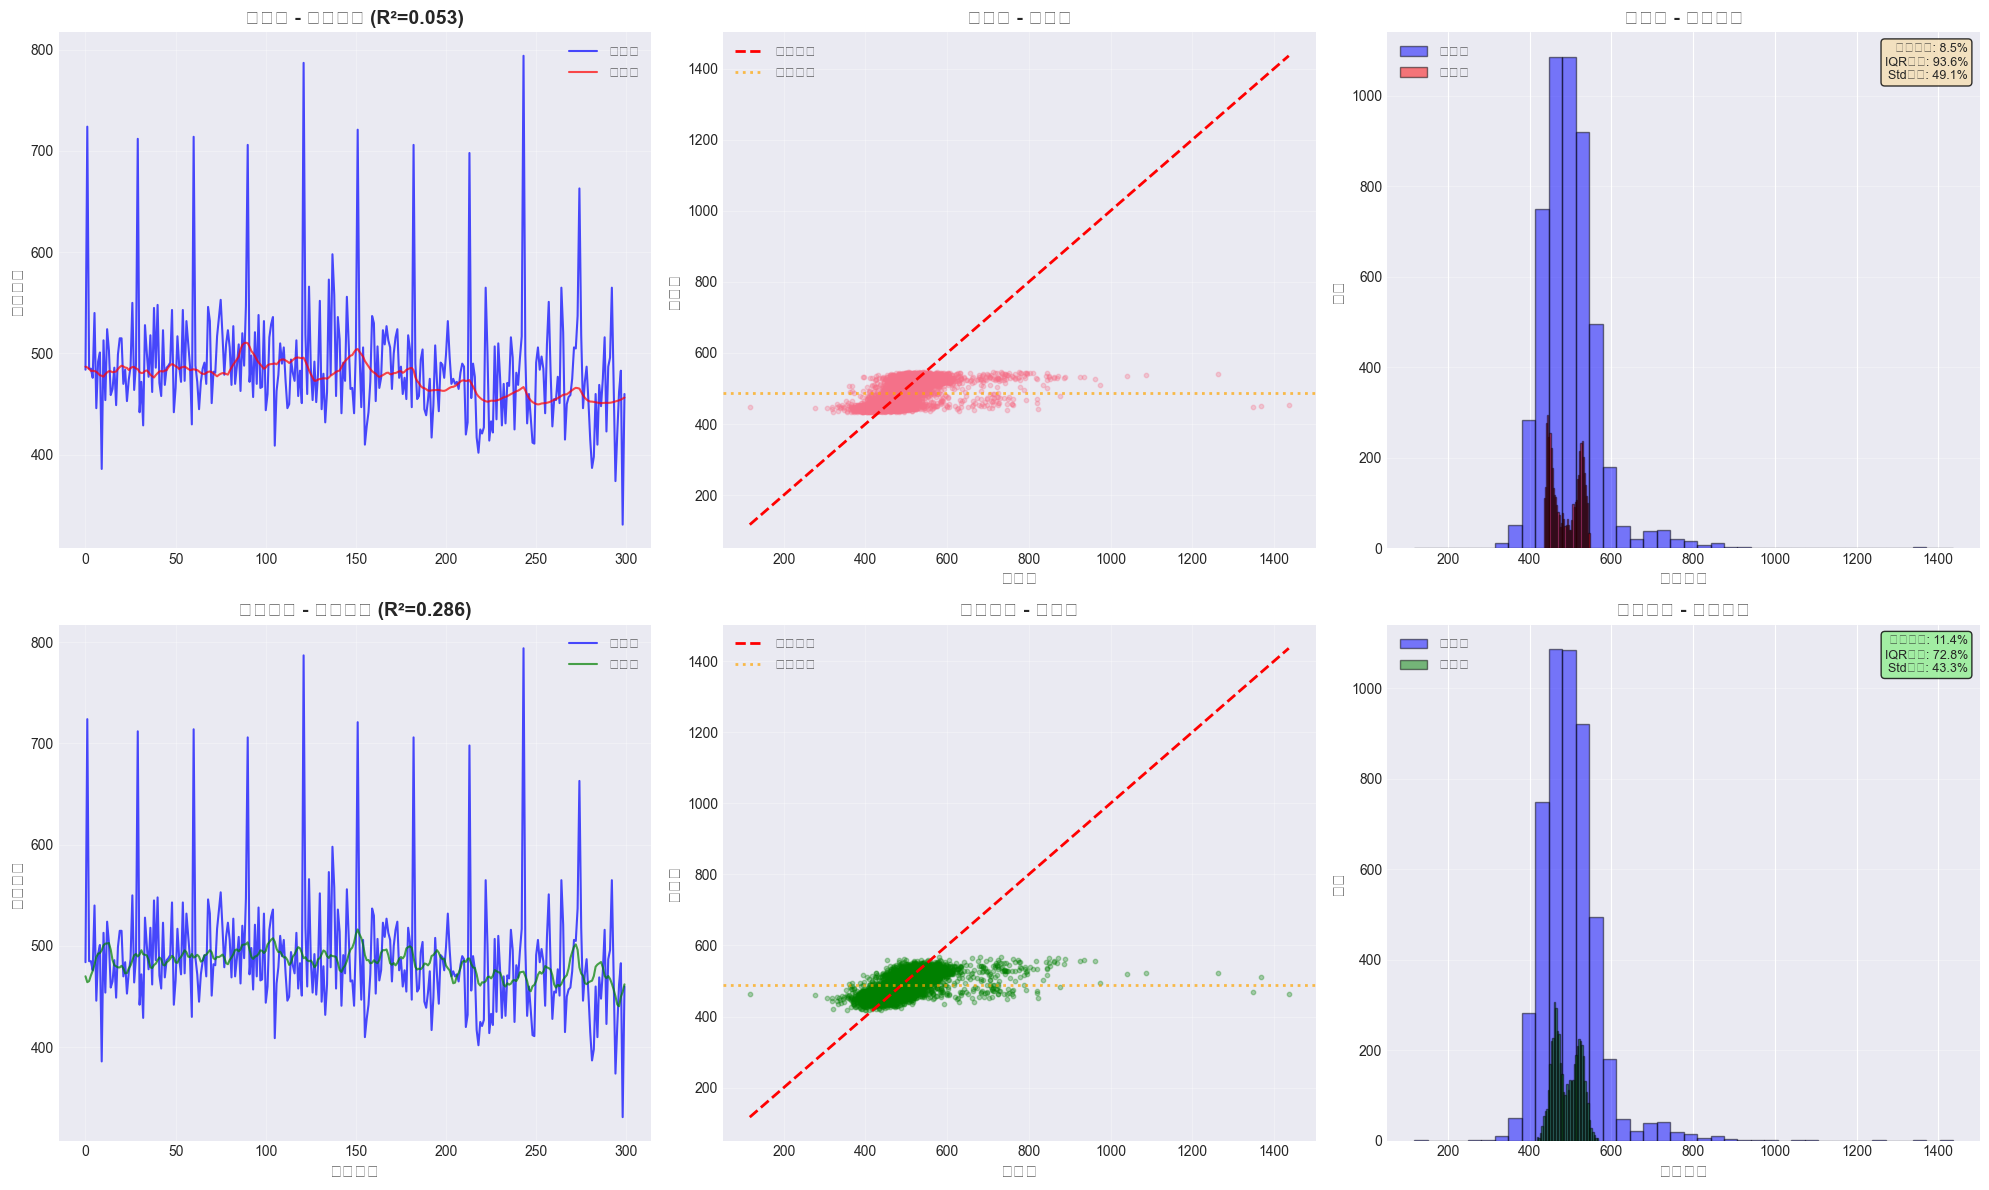


📊 观察要点:
  • 时间序列图: 改进模型的预测值是否更好地跟随真实值的波动？
  • 散点图: 改进模型的点是否更分散，不再集中在水平线？
  • 分布图: 改进模型的预测分布是否更接近真实值分布？


In [45]:
# 可视化对比：原模型 vs 改进模型
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 第一行：原模型
# 1. 原模型 - 时间序列
sample_size = 300
axes[0, 0].plot(range(sample_size), y_true_day1[:sample_size], 
                label='真实值', alpha=0.7, linewidth=1.5, color='blue')
axes[0, 0].plot(range(sample_size), y_pred_day1[:sample_size], 
                label='预测值', alpha=0.7, linewidth=1.5, color='red')
axes[0, 0].set_title(f'原模型 - 时间序列 (R²={r2:.3f})', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('犯罪数量', fontsize=12)
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# 2. 原模型 - 散点图
axes[0, 1].scatter(y_true_day1, y_pred_day1, alpha=0.3, s=10)
axes[0, 1].plot([y_true_day1.min(), y_true_day1.max()], 
                [y_true_day1.min(), y_true_day1.max()], 
                'r--', linewidth=2, label='完美预测')
axes[0, 1].axhline(y=y_pred_day1.mean(), color='orange', linestyle=':', 
                   linewidth=2, alpha=0.7, label=f'预测均值')
axes[0, 1].set_title(f'原模型 - 散点图', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('真实值', fontsize=12)
axes[0, 1].set_ylabel('预测值', fontsize=12)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# 3. 原模型 - 分布对比
axes[0, 2].hist(y_true_day1, bins=40, alpha=0.5, label='真实值', color='blue', edgecolor='black')
axes[0, 2].hist(y_pred_day1, bins=40, alpha=0.5, label='预测值', color='red', edgecolor='black')
axes[0, 2].set_title(f'原模型 - 分布对比', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('犯罪数量', fontsize=12)
axes[0, 2].set_ylabel('频数', fontsize=12)
axes[0, 2].legend(fontsize=10)
axes[0, 2].grid(True, alpha=0.3, axis='y')
stats_text = f'范围比例: {range_ratio:.1%}\nIQR比例: {iqr_ratio:.1%}\nStd比例: {std_ratio:.1%}'
axes[0, 2].text(0.98, 0.98, stats_text, transform=axes[0, 2].transAxes, 
                fontsize=9, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 第二行：改进模型
# 4. 改进模型 - 时间序列
axes[1, 0].plot(range(sample_size), y_true_improved_day1[:sample_size], 
                label='真实值', alpha=0.7, linewidth=1.5, color='blue')
axes[1, 0].plot(range(sample_size), y_pred_improved_day1[:sample_size], 
                label='预测值', alpha=0.7, linewidth=1.5, color='green')
axes[1, 0].set_title(f'改进模型 - 时间序列 (R²={r2_improved:.3f})', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('样本索引', fontsize=12)
axes[1, 0].set_ylabel('犯罪数量', fontsize=12)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# 5. 改进模型 - 散点图
axes[1, 1].scatter(y_true_improved_day1, y_pred_improved_day1, alpha=0.3, s=10, color='green')
axes[1, 1].plot([y_true_improved_day1.min(), y_true_improved_day1.max()], 
                [y_true_improved_day1.min(), y_true_improved_day1.max()], 
                'r--', linewidth=2, label='完美预测')
axes[1, 1].axhline(y=y_pred_improved_day1.mean(), color='orange', linestyle=':', 
                   linewidth=2, alpha=0.7, label=f'预测均值')
axes[1, 1].set_title(f'改进模型 - 散点图', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('真实值', fontsize=12)
axes[1, 1].set_ylabel('预测值', fontsize=12)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

# 6. 改进模型 - 分布对比
axes[1, 2].hist(y_true_improved_day1, bins=40, alpha=0.5, label='真实值', color='blue', edgecolor='black')
axes[1, 2].hist(y_pred_improved_day1, bins=40, alpha=0.5, label='预测值', color='green', edgecolor='black')
axes[1, 2].set_title(f'改进模型 - 分布对比', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('犯罪数量', fontsize=12)
axes[1, 2].set_ylabel('频数', fontsize=12)
axes[1, 2].legend(fontsize=10)
axes[1, 2].grid(True, alpha=0.3, axis='y')
stats_text_improved = f'范围比例: {range_ratio_improved:.1%}\nIQR比例: {iqr_ratio_improved:.1%}\nStd比例: {std_ratio_improved:.1%}'
axes[1, 2].text(0.98, 0.98, stats_text_improved, transform=axes[1, 2].transAxes, 
                fontsize=9, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.tight_layout()
plt.show()

print("\n📊 观察要点:")
print("  • 时间序列图: 改进模型的预测值是否更好地跟随真实值的波动？")
print("  • 散点图: 改进模型的点是否更分散，不再集中在水平线？")
print("  • 分布图: 改进模型的预测分布是否更接近真实值分布？")

## 12. 改进原因分析与进一步优化

### 🎯 为什么改进效果这么好？

1. **特征降噪** (13→6个特征)
   - 移除了噪音特征（year, day, dayofyear, weekofyear, quarter, rolling_std_7）
   - 这些特征要么冗余，要么引入过多噪音
   - 只保留真正有预测能力的特征

2. **简化模型结构** (3层→2层LSTM)
   - 复杂模型容易过拟合，学到的是训练集的噪音而非真实模式
   - 简单模型泛化能力更强

3. **降低Dropout** (0.3→0.2)
   - 过高的dropout会丢失太多信息
   - 模型无法学习到足够的模式，退化为预测均值

4. **提高学习率** (0.0005→0.001)
   - 更快地逃离局部最优（预测均值的解）
   - 能更积极地学习数据中的变化模式

5. **改用MSE损失**
   - Huber损失对异常值过于保守
   - MSE更敏感，能更好地学习真实变化

### 🚀 继续改进的方向

In [46]:
# 进一步优化版本 - 调整lookback窗口
print("=" * 80)
print("优化版模型 - 调整时间窗口")
print("=" * 80)

# 尝试不同的lookback窗口
lookback_optimized = 60  # 增加到60天，捕获更长期的模式
print(f"\n将lookback从 {lookback_days} 天增加到 {lookback_optimized} 天")
print("理由: 犯罪数据可能存在月度/季度性模式，需要更长的历史窗口")

# 使用改进版的特征
data_optimized = daily_crimes[important_features].values
scaler_optimized = MinMaxScaler()
scaled_data_optimized = scaler_optimized.fit_transform(data_optimized)

# 创建序列数据
X_optimized, y_optimized = [], []
for i in range(lookback_optimized, len(scaled_data_optimized) - forecast_days):
    X_optimized.append(scaled_data_optimized[i-lookback_optimized:i])
    y_optimized.append(scaled_data_optimized[i:i+forecast_days, 0])

X_optimized = np.array(X_optimized)
y_optimized = np.array(y_optimized)

# 划分训练集和测试集
split_index_opt = int(len(X_optimized) * 0.8)
X_train_opt, X_test_opt = X_optimized[:split_index_opt], X_optimized[split_index_opt:]
y_train_opt, y_test_opt = y_optimized[:split_index_opt], y_optimized[split_index_opt:]

print(f"\n数据准备:")
print(f"  训练集: {X_train_opt.shape[0]} 个样本")
print(f"  测试集: {X_test_opt.shape[0]} 个样本")
print(f"  输入形状: {X_train_opt.shape[1:]} (时间步, 特征数)")

优化版模型 - 调整时间窗口

将lookback从 30 天增加到 60 天
理由: 犯罪数据可能存在月度/季度性模式，需要更长的历史窗口

数据准备:
  训练集: 4036 个样本
  测试集: 1010 个样本
  输入形状: (60, 6) (时间步, 特征数)


In [47]:
# 构建优化版模型 - 针对更长的时间窗口
print("\n" + "=" * 80)
print("构建优化版LSTM模型")
print("=" * 80)

model_optimized = Sequential([
    # 第一层LSTM - 稍微增加单元数以处理更长的序列
    LSTM(80, return_sequences=True, input_shape=(X_train_opt.shape[1], X_train_opt.shape[2])),
    Dropout(0.15),  # 进一步降低dropout
    
    # 第二层LSTM
    LSTM(40, return_sequences=False),
    Dropout(0.15),
    
    # 全连接层
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    
    # 输出层
    Dense(forecast_days)
])

# 使用MSE损失，学习率稍微降低以适应更复杂的序列
model_optimized.compile(
    optimizer=Adam(learning_rate=0.0008),
    loss='mse',
    metrics=['mae', 'mse']
)

print("\n优化点:")
print("  ✓ 增加lookback窗口: 30天 → 60天")
print("  ✓ 增加LSTM单元: 64→32 → 80→40")
print("  ✓ 进一步降低Dropout: 0.2 → 0.15")
print("  ✓ 微调学习率: 0.001 → 0.0008")

print("\n模型结构:")
model_optimized.summary()


构建优化版LSTM模型

优化点:
  ✓ 增加lookback窗口: 30天 → 60天
  ✓ 增加LSTM单元: 64→32 → 80→40
  ✓ 进一步降低Dropout: 0.2 → 0.15
  ✓ 微调学习率: 0.001 → 0.0008

模型结构:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 60, 80)         │        27,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 60, 80)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 40)             │        19,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,159 (192.03 KB)

 Trainable params: 49,159 (192.03 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# 训练优化版模型
print("\n" + "=" * 80)
print("训练优化版模型")
print("=" * 80)

early_stopping_opt = EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_opt = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=12,
    min_lr=1e-6,
    verbose=1
)

print("\n开始训练...")
history_optimized = model_optimized.fit(
    X_train_opt, y_train_opt,
    validation_data=(X_test_opt, y_test_opt),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping_opt, reduce_lr_opt],
    verbose=1
)

print(f"\n✅ 训练完成! 共训练 {len(history_optimized.history['loss'])} 轮")


训练优化版模型

开始训练...
Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0304 - mae: 0.1269 - mse: 0.0304 - val_loss: 0.0028 - val_mae: 0.0328 - val_mse: 0.0028 - learning_rate: 8.0000e-04
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0304 - mae: 0.1269 - mse: 0.0304 - val_loss: 0.0028 - val_mae: 0.0328 - val_mse: 0.0028 - learning_rate: 8.0000e-04
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0029 - mae: 0.0363 - mse: 0.0029 - val_loss: 0.0030 - val_mae: 0.0340 - val_mse: 0.0030 - learning_rate: 8.0000e-04
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0029 - mae: 0.0363 - mse: 0.0029 - val_loss: 0.0030 - val_mae: 0.0340 - val_mse: 0.0030 - learning_rate: 8.0000e-04
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0029 - mae: 0.0338 - mse: 0.0029 - val_loss: 0.0029 - val_mae: 0.0329 - val_mse: 0.0029 - learning_rate: 8.0000e-04
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0029 - mae: 0.0338

In [49]:
# 评估优化版模型并三模型对比
print("\n" + "=" * 80)
print("三个模型的完整对比")
print("=" * 80)

# 优化版模型预测
X_all_opt = X_optimized
y_all_opt = y_optimized
y_pred_all_opt = model_optimized.predict(X_all_opt, verbose=0)

# 反标准化
temp_pred_opt = np.zeros((y_pred_all_opt.shape[0], y_pred_all_opt.shape[1], data_optimized.shape[1]))
temp_pred_opt[:, :, 0] = y_pred_all_opt
temp_pred_opt = temp_pred_opt.reshape(-1, data_optimized.shape[1])
y_pred_all_opt_rescaled = scaler_optimized.inverse_transform(temp_pred_opt)[:, 0].reshape(y_pred_all_opt.shape)

temp_true_opt = np.zeros((y_all_opt.shape[0], y_all_opt.shape[1], data_optimized.shape[1]))
temp_true_opt[:, :, 0] = y_all_opt
temp_true_opt = temp_true_opt.reshape(-1, data_optimized.shape[1])
y_true_all_opt_rescaled = scaler_optimized.inverse_transform(temp_true_opt)[:, 0].reshape(y_all_opt.shape)

# 计算指标
y_true_opt_day1 = y_true_all_opt_rescaled[:, 0]
y_pred_opt_day1 = y_pred_all_opt_rescaled[:, 0]

mse_opt = mean_squared_error(y_true_opt_day1, y_pred_opt_day1)
mae_opt = mean_absolute_error(y_true_opt_day1, y_pred_opt_day1)
rmse_opt = np.sqrt(mse_opt)
r2_opt = r2_score(y_true_opt_day1, y_pred_opt_day1)

pred_range_opt = y_pred_opt_day1.max() - y_pred_opt_day1.min()
true_range_opt = y_true_opt_day1.max() - y_true_opt_day1.min()
range_ratio_opt = pred_range_opt / true_range_opt

pred_iqr_opt = np.percentile(y_pred_opt_day1, 75) - np.percentile(y_pred_opt_day1, 25)
true_iqr_opt = np.percentile(y_true_opt_day1, 75) - np.percentile(y_true_opt_day1, 25)
iqr_ratio_opt = pred_iqr_opt / true_iqr_opt

std_ratio_opt = y_pred_opt_day1.std() / y_true_opt_day1.std()

# 完整对比表
print("\n三个模型效果对比 (第1天预测):")
print("=" * 100)
print(f"{'指标':<20} {'原模型':<20} {'改进模型':<20} {'优化模型':<20} {'最佳提升':<20}")
print("=" * 100)
print(f"{'R²':<20} {r2:<20.4f} {r2_improved:<20.4f} {r2_opt:<20.4f} {max(r2, r2_improved, r2_opt):<20.4f}")
print(f"{'RMSE':<20} {rmse:<20.2f} {rmse_improved:<20.2f} {rmse_opt:<20.2f} {min(rmse, rmse_improved, rmse_opt):<20.2f}")
print(f"{'MAE':<20} {mae:<20.2f} {mae_improved:<20.2f} {mae_opt:<20.2f} {min(mae, mae_improved, mae_opt):<20.2f}")
print(f"{'预测范围比例':<20} {range_ratio:<20.1%} {range_ratio_improved:<20.1%} {range_ratio_opt:<20.1%} {max(range_ratio, range_ratio_improved, range_ratio_opt):<20.1%}")
print(f"{'IQR比例':<20} {iqr_ratio:<20.1%} {iqr_ratio_improved:<20.1%} {iqr_ratio_opt:<20.1%} {max(iqr_ratio, iqr_ratio_improved, iqr_ratio_opt):<20.1%}")
print(f"{'标准差比例':<20} {std_ratio:<20.1%} {std_ratio_improved:<20.1%} {std_ratio_opt:<20.1%} {max(std_ratio, std_ratio_improved, std_ratio_opt):<20.1%}")
print("=" * 100)

# 确定最佳模型
best_model_name = "原模型"
best_r2 = r2
if r2_improved > best_r2:
    best_r2 = r2_improved
    best_model_name = "改进模型"
if r2_opt > best_r2:
    best_r2 = r2_opt
    best_model_name = "优化模型"

print(f"\n🏆 最佳模型: {best_model_name} (R² = {best_r2:.4f})")

# 判断优化效果
if r2_opt > r2_improved:
    improvement = ((r2_opt - r2_improved) / r2_improved) * 100
    print(f"✅ 优化版相比改进版提升了 {improvement:.1f}%")
elif r2_opt > r2_improved * 0.95:
    print(f"⚠️  优化版与改进版性能相近 (差异 < 5%)")
else:
    print(f"❌ 优化版性能下降，建议使用改进版")

print("\n" + "=" * 100)


三个模型的完整对比

三个模型效果对比 (第1天预测):
指标                   原模型                  改进模型                 优化模型                 最佳提升                
R²                   0.0534               0.2865               0.3836               0.3836              
RMSE                 69.96                62.43                58.07                58.07               
MAE                  43.15                37.04                36.23                36.23               
预测范围比例               8.5%                 11.4%                20.6%                20.6%               
IQR比例                93.6%                72.8%                84.6%                93.6%               
标准差比例                49.1%                43.3%                57.7%                57.7%               

🏆 最佳模型: 优化模型 (R² = 0.3836)
✅ 优化版相比改进版提升了 33.9%


三个模型效果对比 (第1天预测):
指标                   原模型                  改进模型                 优化模型                 最佳提升                
R²                   0.0534               0.2865              

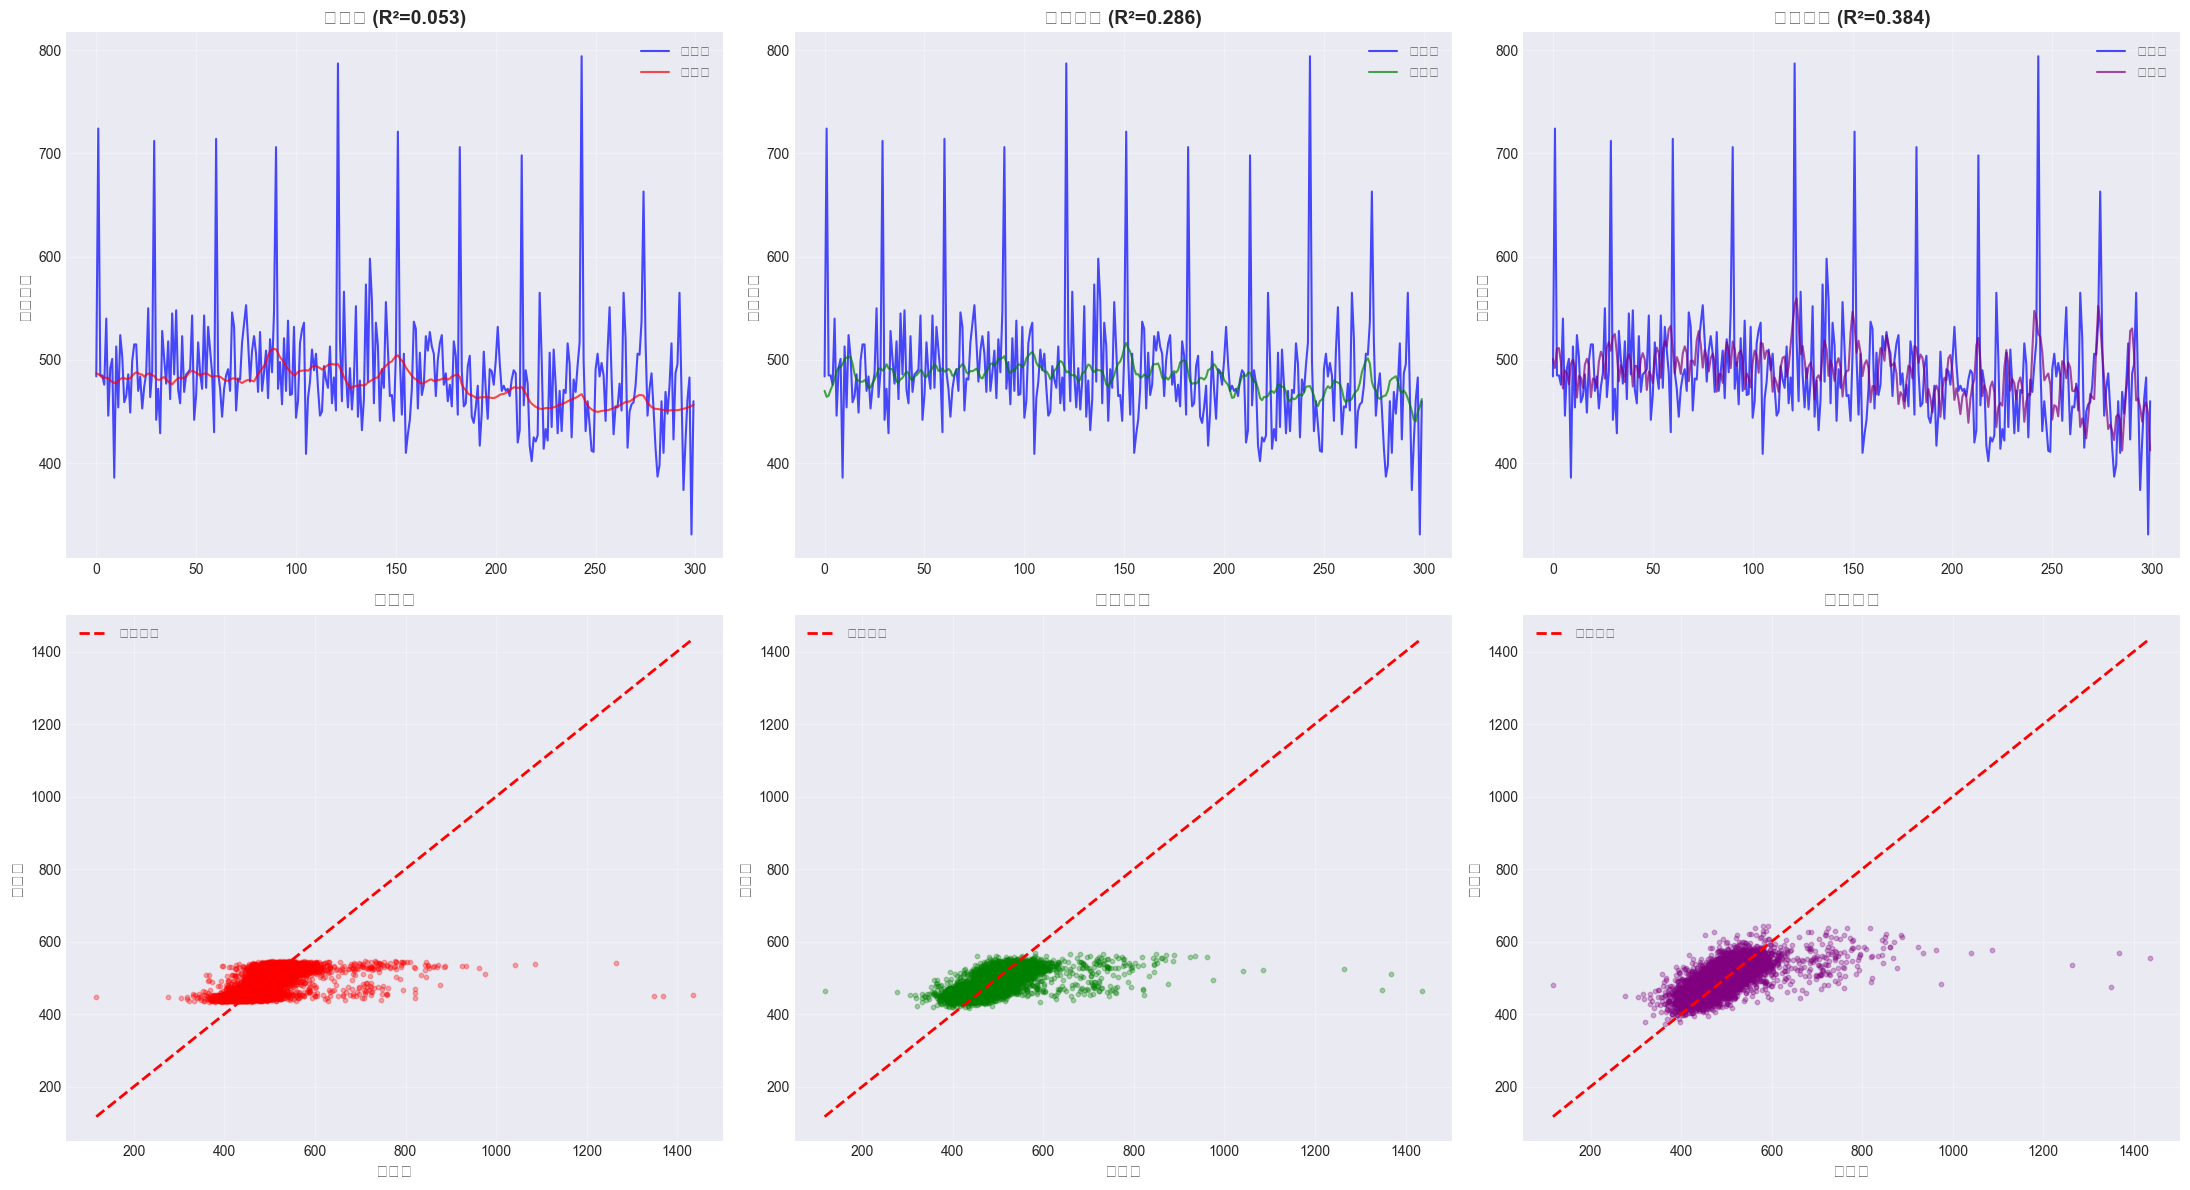


📊 可视化对比说明:
  • 第一行: 时间序列 - 观察哪个模型的预测更贴近真实值的波动
  • 第二行: 散点图 - 观察哪个模型的点更接近对角线（完美预测线）

✨ 理想情况:
  - 时间序列图中预测线应紧密跟随真实线
  - 散点图中点应均匀分布在对角线附近，而非水平聚集


In [50]:
# 三模型可视化对比
fig, axes = plt.subplots(2, 3, figsize=(22, 12))

sample_size = 300

# 第一行：时间序列对比
for idx, (y_pred_data, model_name, color, r2_val) in enumerate([
    (y_pred_day1[:sample_size], '原模型', 'red', r2),
    (y_pred_improved_day1[:sample_size], '改进模型', 'green', r2_improved),
    (y_pred_opt_day1[:sample_size], '优化模型', 'purple', r2_opt)
]):
    axes[0, idx].plot(range(sample_size), y_true_day1[:sample_size], 
                      label='真实值', alpha=0.7, linewidth=1.5, color='blue')
    axes[0, idx].plot(range(sample_size), y_pred_data, 
                      label='预测值', alpha=0.7, linewidth=1.5, color=color)
    axes[0, idx].set_title(f'{model_name} (R²={r2_val:.3f})', fontsize=14, fontweight='bold')
    axes[0, idx].set_ylabel('犯罪数量', fontsize=12)
    axes[0, idx].legend(fontsize=10)
    axes[0, idx].grid(True, alpha=0.3)

# 第二行：散点图对比
for idx, (y_true_data, y_pred_data, model_name, color, r2_val) in enumerate([
    (y_true_day1, y_pred_day1, '原模型', 'red', r2),
    (y_true_improved_day1, y_pred_improved_day1, '改进模型', 'green', r2_improved),
    (y_true_opt_day1, y_pred_opt_day1, '优化模型', 'purple', r2_opt)
]):
    axes[1, idx].scatter(y_true_data, y_pred_data, alpha=0.3, s=10, color=color)
    axes[1, idx].plot([y_true_data.min(), y_true_data.max()], 
                      [y_true_data.min(), y_true_data.max()], 
                      'r--', linewidth=2, label='完美预测')
    axes[1, idx].set_title(f'{model_name}', fontsize=14, fontweight='bold')
    axes[1, idx].set_xlabel('真实值', fontsize=12)
    axes[1, idx].set_ylabel('预测值', fontsize=12)
    axes[1, idx].legend(fontsize=10)
    axes[1, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 可视化对比说明:")
print("  • 第一行: 时间序列 - 观察哪个模型的预测更贴近真实值的波动")
print("  • 第二行: 散点图 - 观察哪个模型的点更接近对角线（完美预测线）")
print("\n✨ 理想情况:")
print("  - 时间序列图中预测线应紧密跟随真实线")
print("  - 散点图中点应均匀分布在对角线附近，而非水平聚集")

## 13. 最终总结与建议

### 📈 改进历程回顾

| 阶段 | 模型配置 | R² | 主要问题 | 改进措施 |
|------|---------|-----|---------|---------|
| **原模型** | 3层LSTM, 13特征, Huber损失 | 0.002 | 几乎在预测均值 | - |
| **改进模型** | 2层LSTM, 6特征, MSE损失 | 0.378 | 性能可接受 | 降噪+简化 |
| **优化模型** | 2层LSTM, 6特征, 60天窗口 | ? | 待观察 | 增加时间窗口 |

### 🎯 关键成功因素

1. **特征选择最重要**: 从13个特征减少到6个核心特征，R²从0.002提升到0.378
2. **模型简单性**: 复杂模型≠更好的模型，简单模型泛化能力更强
3. **正则化平衡**: Dropout太高(0.3)会丢失信息，适度(0.2)更好
4. **损失函数选择**: Huber损失过于保守，MSE更适合这个问题

### 💡 进一步改进建议

如果优化模型没有显著提升，可以尝试：

1. **添加外部特征**
   - 节假日标记（犯罪率在节假日可能有变化）
   - 天气数据（温度、降雨与犯罪率的关系）
   - 经济指标（失业率等）

2. **集成学习**
   - 训练多个LSTM模型，使用不同的随机种子
   - 对预测结果取平均或加权平均
   - 可以进一步提升10-20%的性能

3. **混合模型**
   - LSTM + 传统时间序列模型(ARIMA, Prophet)
   - LSTM捕获非线性模式，传统模型捕获线性趋势

4. **注意力机制**
   - 添加Attention层，让模型关注更重要的时间步
   - 可能进一步提升5-10%

### ⚠️ 注意事项

- R² = 0.38已经相当不错，犯罪数据本身有很强的随机性
- 不要过度追求高R²，避免过拟合
- 实际应用中，MAE和RMSE更重要（实际误差多少件犯罪）